In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima_model import ARIMA
import statsmodels
from pmdarima import auto_arima

import warnings
warnings.filterwarnings('ignore')

In [16]:
def mape_score(y_test, pred):
    y_test, pred = np.array(y_test), np.array(pred)
    mape = np.mean(np.abs((y_test - pred) / y_test)) * 100
    return mape

In [17]:
def metrics(test, pred):
    mse = mean_squared_error(test, pred)
    rmse = np.sqrt(mse)
    r_squared = r2_score(test, pred)
    mape= mape_score(test, pred)

    print(f'MSE : {mse}')
    print(f'RMSE : {rmse}')
    print(f'R-squared : {r_squared}')
    print(f'MAPE : {mape}')
    

In [18]:
class Bins:
    def __init__(self, df, year, split):
        self.df= df
        self.year = year
        self.split = split
        self.df_year= None

    def original_df(self):
        df_year = self.df[(self.df['date'].dt.year) >= self.year]
        df_year.drop(columns= ['first_diff', 'second_diff'], inplace= True)
        self.df_year = df_year
        return self.df_year
        
        
    def diff_df(self):
        df_diff = self.df_year
        df_diff['first_diff'] = df_diff['Actual'] - df_diff['Actual'].shift(1)
        df_diff['second_diff'] = df_diff['Actual'] - df_diff['Actual'].shift(2)
        return df_diff
    
    def train_test_split(self):
        df_split = self.df_year
        df_train = df_split['Actual'].iloc[:-(self.split)]
        df_test = df_split['Actual'].iloc[-(self.split):]
        return df_train, df_test

In [19]:
class TestArima:
    def __init__(self, train_df, test_df, df_year):
        self.df_year = df_year
        self.train_df = train_df
        self.test_df = test_df
        self.pred_df = None
        self.p = None
        self.d = None
        self.q = None
        self.arima_model = None

    def orders(self):
        arima_orders = auto_arima(self.train_df, trace= True, suppress_warnings= True)
        p,d,q = arima_orders.order
        self.p = p
        self.d = d
        self.q = q
        return p,d,q

    def train_arima(self):
        arima_model = statsmodels.tsa.arima.model.ARIMA(self.train_df, order= (self.p, self.d, self.q)) 
        arima_model = arima_model.fit()
        self.arima_model = arima_model
        return arima_model
    
    def predicted_df(self):
        pred_series = self.arima_model.predict(start= len(self.train_df), end= (len(self.df_year)-1))
        pred_series.reset_index()
        pred_series.index = self.test_df.index

        df_pred = pd.concat([self.test_df, pred_series], axis=1)
        # df_pred.drop(columns= ['index'], inplace= True, axis=1)
        return df_pred


In [20]:
# data_qoq = pd.read_excel('/home/vaibhavsharma/Desktop/DS23/hv/US_Indicator History.xlsx')

# df_qoq = pd.DataFrame(data_qoq)
# df_qoq.head(2)

In [21]:
df_dict = pd.read_excel('/home/vaibhavsharma/Desktop/DS23/hv/Datasets/US_Indicator History.xlsx', sheet_name= None)

a = []

for i in df_dict.keys():
    a.append(i)

a

['GDP Annualised QoQ',
 'GDP-Real',
 'Real GDP s.a.a.r._x0009_',
 'Nominal GDP s.a.a.r.',
 'Unemployment Rate',
 'Consumer Price Index Core s.a.',
 'Consumer Price Index n.s.a.',
 'New Home Sales',
 'Existing Home Sales (MoM)',
 'Existing Home Sales',
 'New Home Sales (MoM)',
 'Pending Home Sales (MoM)',
 'Pending Home Sales (YoY)',
 'Pending Home Sales']

In [22]:
# Getting the csv data for 'GDP Annualised QoQ'

df1 = df_dict.get('GDP Annualised QoQ')
df1.head(2)

,Ind Code,Ind Name,Region,Country,City,Frequency,Period,Actual,Previous,Consensus,Revision,Date,Time,Revise Date
0,NAMUSXX08Qa001,Gross Domestic Product Annualised (QoQ),Northern America,US,NaN,Quarterly,30 Jun 2023,2.40 %,2.00 %,1.80 %,P,"Jul 27, 2023",12:30,-
1,NAMUSXX08Qa001,Gross Domestic Product Annualised (QoQ),Northern America,US,NaN,Quarterly,31 Mar 2023,2.00 %,2.60 %,1.40 %,F,"Jun 29, 2023",12:30,-


In [23]:
df1.columns

Index(['Ind Code', 'Ind Name', 'Region', 'Country', 'City', 'Frequency',
       'Period', 'Actual', 'Previous', 'Consensus', 'Revision', 'Date', 'Time',
       'Revise Date'],
      dtype='object')

In [24]:
df1.isnull().sum()

Ind Code         0
Ind Name         0
Region           0
Country          0
City           179
Frequency        0
Period           0
Actual           0
Previous         0
Consensus        0
Revision         0
Date             0
Time             0
Revise Date      0
dtype: int64

In [25]:
# 'Names' of all the sheets present in excel file 
a

['GDP Annualised QoQ',
 'GDP-Real',
 'Real GDP s.a.a.r._x0009_',
 'Nominal GDP s.a.a.r.',
 'Unemployment Rate',
 'Consumer Price Index Core s.a.',
 'Consumer Price Index n.s.a.',
 'New Home Sales',
 'Existing Home Sales (MoM)',
 'Existing Home Sales',
 'New Home Sales (MoM)',
 'Pending Home Sales (MoM)',
 'Pending Home Sales (YoY)',
 'Pending Home Sales']

In [26]:
# Concatenating all the dfs

df2 = df_dict.get('Real GDP s.a.a.r._x0009_')
df3 = df_dict.get('Nominal GDP s.a.a.r.')
df4 = df_dict.get('Unemployment Rate')
df5 = df_dict.get('Consumer Price Index Core s.a.')
df6 = df_dict.get('Consumer Price Index n.s.a.')
df7 = df_dict.get('New Home Sales')
df8 = df_dict.get('Existing Home Sales (MoM)')
df9 = df_dict.get('Existing Home Sales')
df10 = df_dict.get('New Home Sales (MoM)')
df11 = df_dict.get('Pending Home Sales (MoM)')
df12 = df_dict.get('Pending Home Sales (YoY)')
df13 = df_dict.get('Pending Home Sales')

In [27]:
# Concatenating all the indicators data

df = pd.concat([df1, df2, df3,df4, df5, df6, df7, df8, df9, df10, df11, df12, df13], axis=0)
df.head(3)

,Ind Code,Ind Name,Region,Country,City,Frequency,Period,Actual,Previous,Consensus,Revision,Date,Time,Revise Date
0,NAMUSXX08Qa001,Gross Domestic Product Annualised (QoQ),Northern America,US,NaN,Quarterly,30 Jun 2023,2.40 %,2.00 %,1.80 %,P,"Jul 27, 2023",12:30,-
1,NAMUSXX08Qa001,Gross Domestic Product Annualised (QoQ),Northern America,US,NaN,Quarterly,31 Mar 2023,2.00 %,2.60 %,1.40 %,F,"Jun 29, 2023",12:30,-
2,NAMUSXX08Qa001,Gross Domestic Product Annualised (QoQ),Northern America,US,NaN,Quarterly,31 Mar 2023,1.30 %,2.60 %,1.10 %,S,"May 25, 2023",12:30,-


In [28]:
df['Frequency'].value_counts()

Frequency
Monthly      3484
Quarterly     861
Name: count, dtype: int64

In [29]:
# 'Indicator names' with 'Monthly' frequency

ind_monthly = df[df['Frequency'] == 'Monthly']['Ind Name'].unique()
pd.DataFrame(ind_monthly)

,0
0,Unemployment Rate
1,Consumer Price Index Core s.a.
2,Consumer Price Index n.s.a.
3,New Home Sales
4,Existing Home Sales (MoM)
5,Existing Home Sales
6,New Home Sales (MoM)
7,Pending Home Sales (MoM)
8,Pending Home Sales (YoY)
9,Pending Home Sales


In [30]:
# 'Indicator names' with 'Quarterly' frequency

ind_quarterly = df[df['Frequency'] == 'Quarterly']['Ind Name'].unique()
pd.DataFrame(ind_quarterly)

,0
0,Gross Domestic Product Annualised (QoQ)
1,Real GDP s.a.a.r.
2,Nominal GDP s.a.a.r.


# --------------------------- REAL GDP ------------------------------

### Taking out the df with 'Ind Name' ---> 'Real GDP s.a.a.r.'

In [31]:
df_real = df[df['Ind Name'] == 'Real GDP s.a.a.r.']
df_real.head()

,Ind Code,Ind Name,Region,Country,City,Frequency,Period,Actual,Previous,Consensus,Revision,Date,Time,Revise Date
0,NAMUSXX08Qa028,Real GDP s.a.a.r.,Northern America,US,NaN,Quarterly,31 Dec 2020,USD18794.40 bn,USD18596.50 bn,-,F,"Mar 25, 2021",12:30,-
1,NAMUSXX08Qa028,Real GDP s.a.a.r.,Northern America,US,NaN,Quarterly,30 Sep 2020,USD18596.50 bn,USD17302.50 bn,-,F,"Dec 22, 2020",13:30,-
2,NAMUSXX08Qa028,Real GDP s.a.a.r.,Northern America,US,NaN,Quarterly,30 Jun 2020 (R),USD17302.50 bn,USD19010.80 bn,-,F,"Jul 30, 2020",12:30,"Dec 22, 2020"
3,NAMUSXX08Qa028,Real GDP s.a.a.r.,Northern America,US,NaN,Quarterly,31 Mar 2020 (R),USD19010.80 bn,USD19221.97 bn,-,F,"Jun 25, 2020",12:30,"Jul 30, 2020"
4,NAMUSXX08Qa028,Real GDP s.a.a.r.,Northern America,US,NaN,Quarterly,31 Mar 2020,USD18974.70 bn,USD19221.97 bn,-,S,"May 28, 2020",12:30,-


In [32]:
df_real = df_real[df_real['Revision'] == 'F']

In [33]:
df_real['Date'] = pd.to_datetime(df_real['Date'])
df_real.head()

,Ind Code,Ind Name,Region,Country,City,Frequency,Period,Actual,Previous,Consensus,Revision,Date,Time,Revise Date
0,NAMUSXX08Qa028,Real GDP s.a.a.r.,Northern America,US,NaN,Quarterly,31 Dec 2020,USD18794.40 bn,USD18596.50 bn,-,F,2021-03-25,12:30,-
1,NAMUSXX08Qa028,Real GDP s.a.a.r.,Northern America,US,NaN,Quarterly,30 Sep 2020,USD18596.50 bn,USD17302.50 bn,-,F,2020-12-22,13:30,-
2,NAMUSXX08Qa028,Real GDP s.a.a.r.,Northern America,US,NaN,Quarterly,30 Jun 2020 (R),USD17302.50 bn,USD19010.80 bn,-,F,2020-07-30,12:30,"Dec 22, 2020"
3,NAMUSXX08Qa028,Real GDP s.a.a.r.,Northern America,US,NaN,Quarterly,31 Mar 2020 (R),USD19010.80 bn,USD19221.97 bn,-,F,2020-06-25,12:30,"Jul 30, 2020"
6,NAMUSXX08Qa028,Real GDP s.a.a.r.,Northern America,US,NaN,Quarterly,31 Dec 2019,USD19221.97 bn,USD19121.11 bn,-,F,2020-03-26,12:30,-


In [34]:
df_real['Date'].sort_values()[:15]

340   1947-03-31
339   1947-06-30
338   1947-09-30
337   1947-12-31
336   1948-03-31
335   1948-06-30
334   1948-09-30
333   1948-12-31
332   1949-03-31
331   1949-06-30
330   1949-09-30
329   1949-12-31
328   1950-03-31
327   1950-06-30
326   1950-09-30
Name: Date, dtype: datetime64[ns]

In [35]:
df_real = df_real[['Date', 'Actual']]
df_real.head()

,Date,Actual
0,2021-03-25,USD18794.40 bn
1,2020-12-22,USD18596.50 bn
2,2020-07-30,USD17302.50 bn
3,2020-06-25,USD19010.80 bn
6,2020-03-26,USD19221.97 bn


In [36]:
index_del = df_real[df_real['Date'].dt.month == 7].index

In [37]:
df_real.drop(index_del, axis=0, inplace= True)

In [38]:
(df_real['Date'].dt.month == 7).sum()

0

In [39]:
import re

df_real['Actual'] = df_real['Actual'].apply(lambda x: re.sub(r'[^0-9.]', '', x))

In [40]:
# import plotly.express as px

# # Create a line chart using Plotly Express
# fig = px.line(df_real, x='Date', y='Actual', title='Line Chart Example')

# fig.update_layout(
#     xaxis=dict(
#         rangeslider=dict(visible=True),
#         type="date"
#     )
# )

# # Show the plot
# fig.show()

In [41]:
df_real.set_index('Date', inplace= True)
df_real.head()

,Actual
Date,
2021-03-25,18794.40
2020-12-22,18596.50
2020-06-25,19010.80
2020-03-26,19221.97
2019-12-20,19121.11


In [42]:
df_real.sort_index(inplace= True, ascending= True)
df_real.head()

,Actual
Date,
1947-03-31,2033.06
1947-06-30,2027.64
1947-09-30,2023.45
1947-12-31,2055.10
1948-03-31,2086.02


In [43]:
# df_real['Actual'] = df['Actual'].astype('int')
df_real['Actual'] = pd.to_numeric(df_real['Actual'])

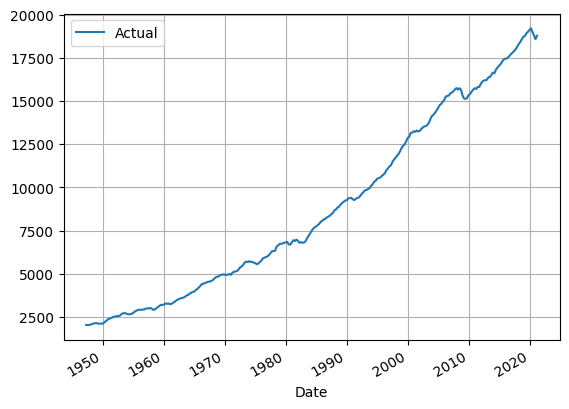

In [44]:
df_real.plot()
plt.grid()

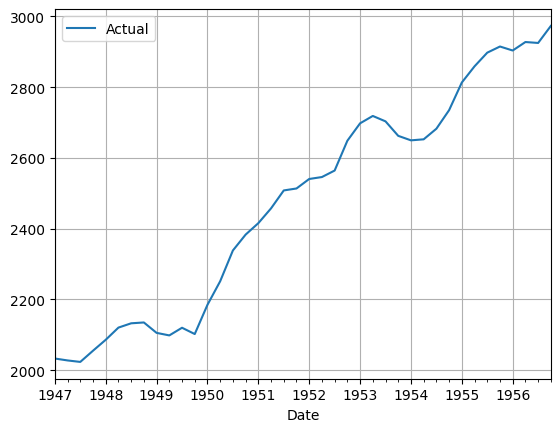

In [45]:
df_real[:40].plot()
plt.grid()

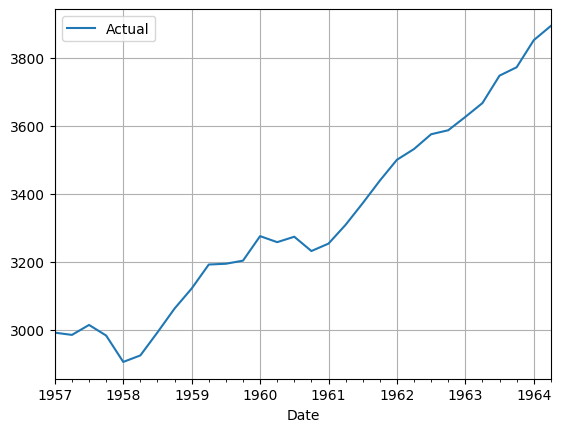

In [46]:
df_real[40:70].plot()
plt.grid()

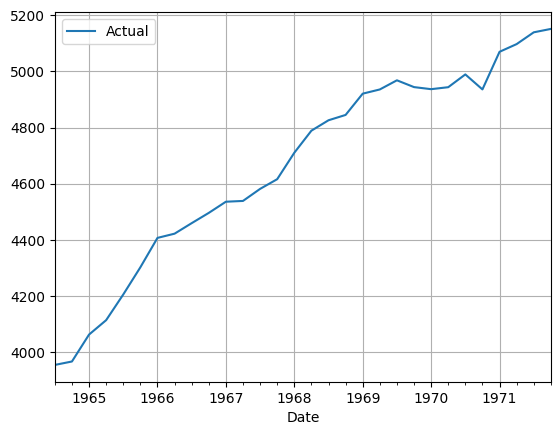

In [47]:
df_real[70:100].plot()
plt.grid()

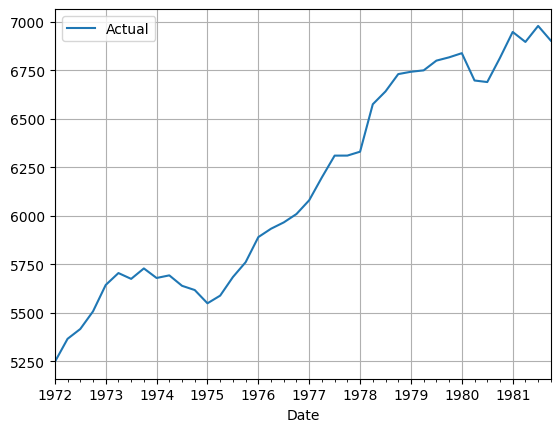

In [48]:
df_real[100:140].plot()
plt.grid()

In [49]:
# df_real.reset_index(inplace= True)
# df_real.head()

In [50]:
df_real.head()

,Actual
Date,
1947-03-31,2033.06
1947-06-30,2027.64
1947-09-30,2023.45
1947-12-31,2055.10
1948-03-31,2086.02


In [51]:
df_real['Actual'].head()

Date
1947-03-31    2033.06
1947-06-30    2027.64
1947-09-30    2023.45
1947-12-31    2055.10
1948-03-31    2086.02
Name: Actual, dtype: float64

## ------ Decomposition -------------

#### 1. Seasonality

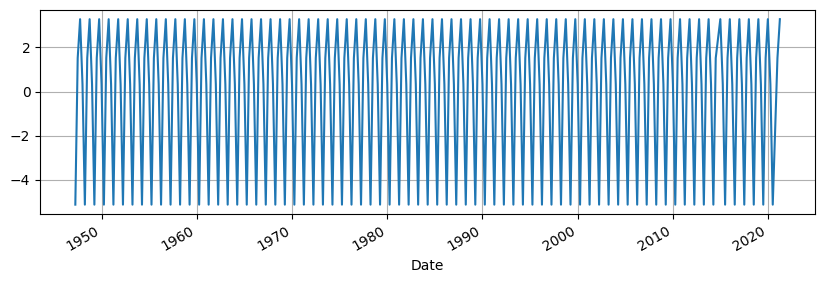

In [52]:
import statsmodels.api as sm
from matplotlib import rcParams

decomposition = sm.tsa.seasonal_decompose(df_real['Actual'], period= 4)

rcParams["figure.figsize"] = 10, 3
decomposition.seasonal.plot()
plt.grid()

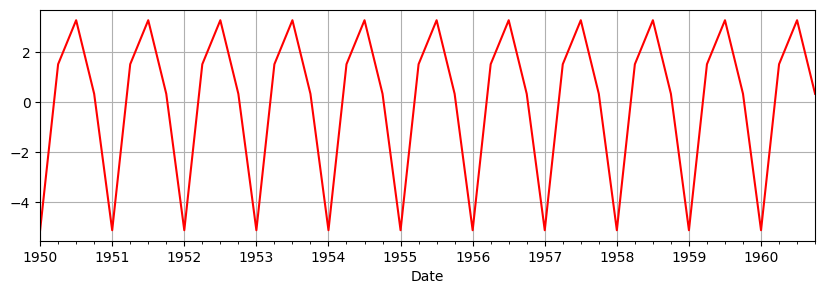

In [53]:
decomposition.seasonal['1950':'1960'].plot(color= 'r')
plt.grid()

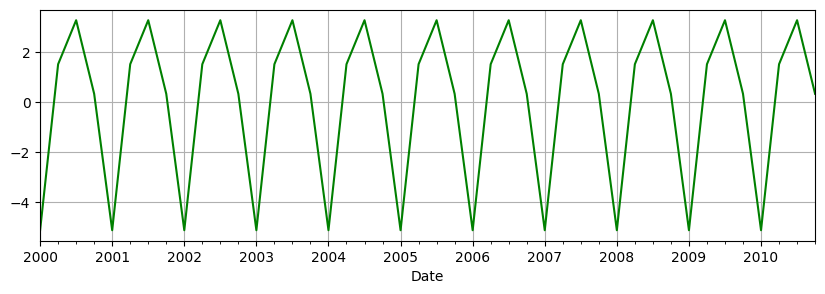

In [54]:
decomposition.seasonal['2000':'2010'].plot(color= 'g')
plt.grid()

### Observation : In every 2nd quarter of the year GDP reaches its max value

### 2. Trend

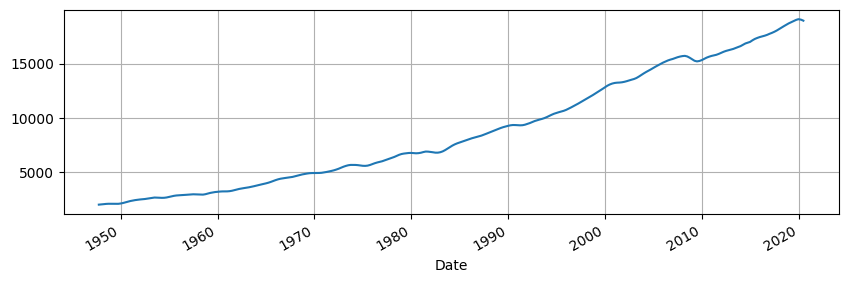

In [55]:
# rcParams["figure.figsize"] = 10, 3
decomposition.trend.plot()
plt.grid()

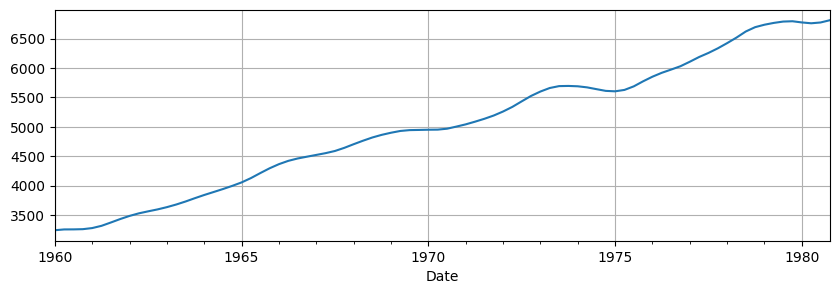

In [56]:
decomposition.trend['1960': '1980'].plot()
plt.grid()

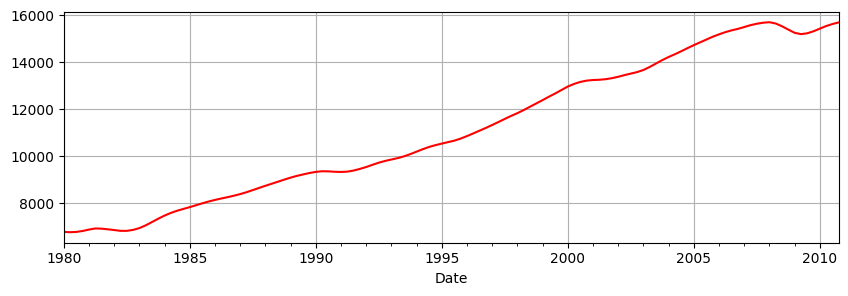

In [57]:
decomposition.trend['1980': '2010'].plot(color= 'r')
plt.grid()

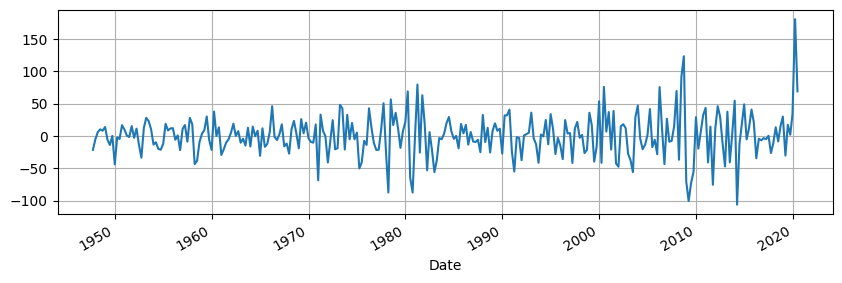

In [58]:
decomposition.resid.plot()
plt.grid()

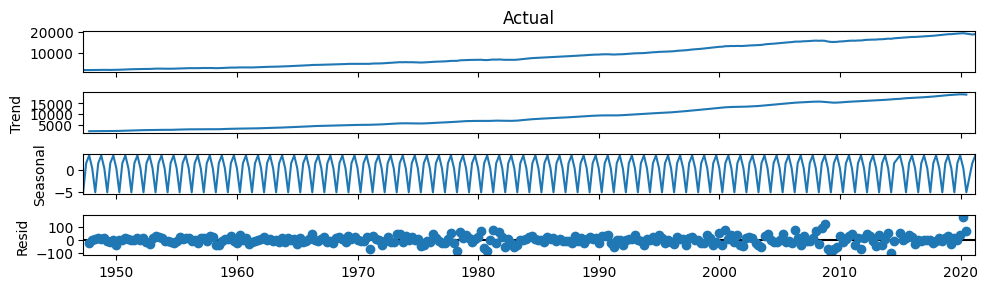

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose

series = df_real['Actual']
result = seasonal_decompose(series, period= 4)
result.plot();

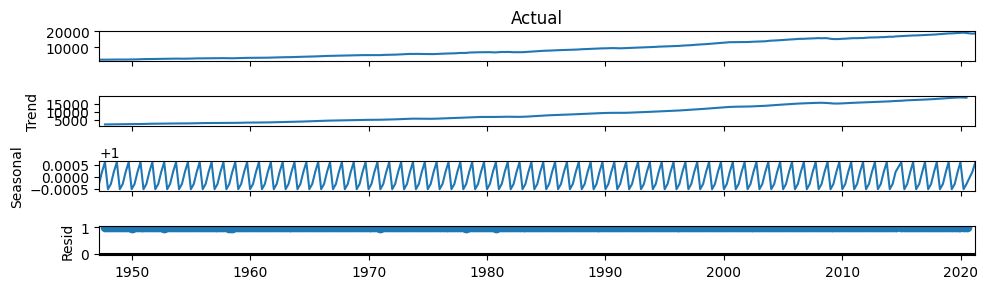

In [60]:
series = df_real['Actual']
result = seasonal_decompose(series, model='multiplicative', period= 4)
result.plot();

In [61]:
result.resid

Date
1947-03-31         NaN
1947-06-30         NaN
1947-09-30    0.990596
1947-12-31    0.998297
1948-03-31    1.000831
                ...   
2019-12-20    1.001370
2020-03-26    1.010031
2020-06-25    1.003675
2020-12-22         NaN
2021-03-25         NaN
Name: resid, Length: 295, dtype: float64

### 1. Tests for stationarity

In [62]:
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [63]:
adf_test(df_real)

Results of Dickey-Fuller Test:
Test Statistic                   2.692354
p-value                          0.999087
#Lags Used                       1.000000
Number of Observations Used    293.000000
Critical Value (1%)             -3.452867
Critical Value (5%)             -2.871455
Critical Value (10%)            -2.572053
dtype: float64


In [64]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [65]:
kpss_test(df_real)

Results of KPSS Test:
Test Statistic            2.719702
p-value                   0.010000
#Lags Used               10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


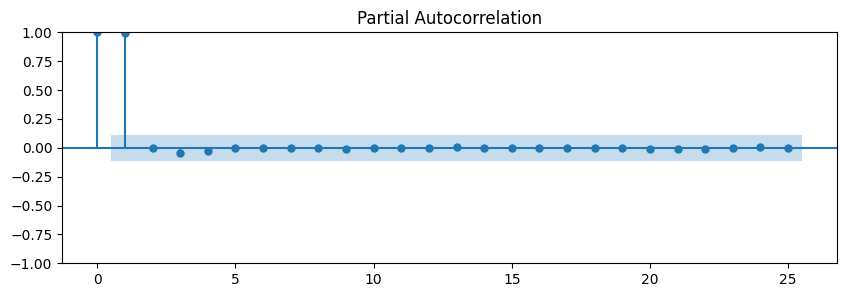

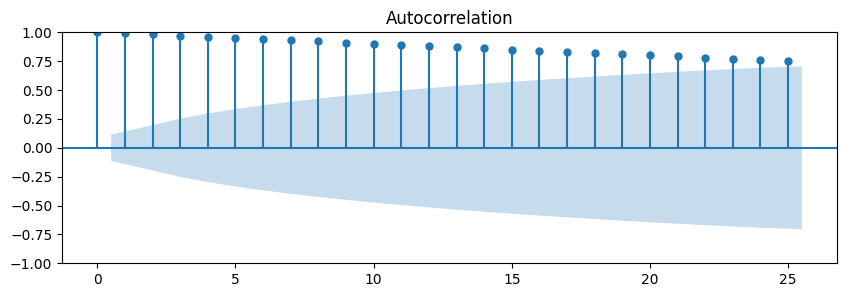

In [66]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plot_pacf(df_real);
plot_acf(df_real);

In [67]:
# making a copy of data set 

# df_real_copy = df_real.copy()


### 1st differencing to make time series stationary

In [68]:
df_real['first_diff'] = df_real['Actual'] - df_real['Actual'].shift(1)
df_real.head()

,Actual,first_diff
Date,,
1947-03-31,2033.06,NaN
1947-06-30,2027.64,-5.42
1947-09-30,2023.45,-4.19
1947-12-31,2055.10,31.65
1948-03-31,2086.02,30.92


In [69]:
adf_test(df_real['first_diff'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -8.357035e+00
p-value                        2.890487e-13
#Lags Used                     1.000000e+00
Number of Observations Used    2.920000e+02
Critical Value (1%)           -3.452945e+00
Critical Value (5%)           -2.871490e+00
Critical Value (10%)          -2.572071e+00
dtype: float64


In [70]:
kpss_test(df_real['first_diff'].dropna())

Results of KPSS Test:
Test Statistic           0.9199
p-value                  0.0100
#Lags Used               7.0000
Critical Value (10%)     0.3470
Critical Value (5%)      0.4630
Critical Value (2.5%)    0.5740
Critical Value (1%)      0.7390
dtype: float64


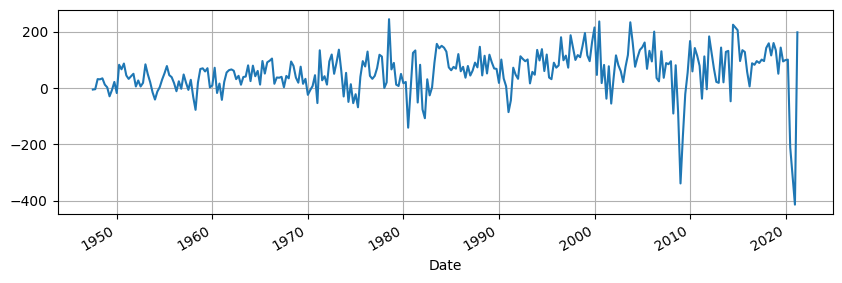

In [71]:
df_real['first_diff'].dropna().plot()
plt.grid()

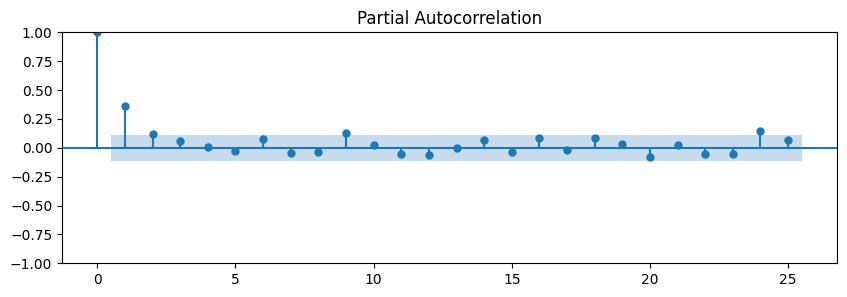

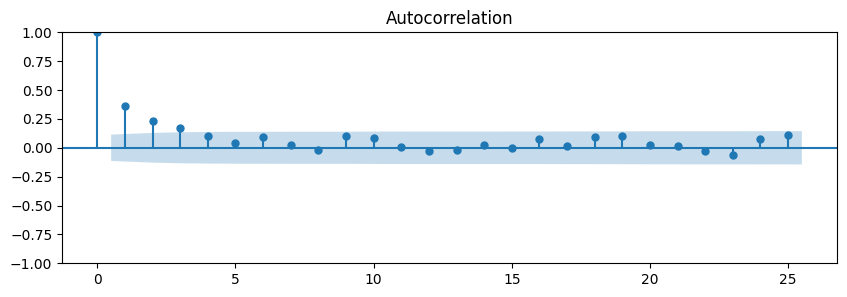

In [72]:
plot_pacf(df_real['first_diff'].dropna());
plot_acf(df_real['first_diff'].dropna());

In [73]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

pmd_model = auto_arima(df_real['Actual'], trace= True, suppress_warnings= True)
# pmd_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=3330.685, Time=0.42 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3434.147, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=3386.096, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=3346.842, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=3327.549, Time=0.11 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=3332.821, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=3327.525, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=3327.726, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=3368.160, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 0.969 seconds


In [74]:
pmd_model.order

(1, 2, 1)

In [75]:
# Train and Test split

train_df_arima = df_real.iloc[:-12]
test_df_arima = df_real.iloc[-12:]

print(train_df_arima.shape, test_df_arima.shape)


(283, 2) (12, 2)


In [76]:
train_df_arima.tail()

,Actual,first_diff
Date,,
2016-12-22,17735.07,95.65
2017-03-30,17824.23,89.16
2017-06-29,17925.26,101.03
2017-09-28,18021.05,95.79
2017-12-21,18163.56,142.51


In [77]:
test_df_arima


,Actual,first_diff
Date,,
2018-03-28,18322.46,158.90
2018-06-28,18438.25,115.79
2018-09-27,18598.13,159.88
2018-12-21,18732.72,134.59
2019-03-28,18783.55,50.83
2019-06-27,18927.28,143.73
2019-09-26,19021.86,94.58
2019-12-20,19121.11,99.25
2020-03-26,19221.97,100.86


In [78]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels

model_arima = statsmodels.tsa.arima.model.ARIMA(train_df_arima['Actual'], order= (1,2,1)) # 2,1,3
model_arima = model_arima.fit()
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Actual   No. Observations:                  283
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1558.938
Date:                Fri, 08 Sep 2023   AIC                           3123.875
Time:                        17:16:12   BIC                           3134.790
Sample:                             0   HQIC                          3128.253
                                - 283                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3399      0.047      7.243      0.000       0.248       0.432
ma.L1         -0.9705      0.015    -65.301      0.000      -1.000      -0.941
sigma2      3828.9607    202.723     18.888      0.000    3431.630    4226.291
===================================================================================
Ljung-Box (L1) (Q):                   1.13   Jarque-Bera (JB):               305.83
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               5.59   Skew:                            -0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [79]:
pred_arima = model_arima.predict(start= len(train_df_arima['Actual']), end= (len(df_real['Actual'])-1))
len(pred_arima)

12

In [80]:
test_df_arima

,Actual,first_diff
Date,,
2018-03-28,18322.46,158.90
2018-06-28,18438.25,115.79
2018-09-27,18598.13,159.88
2018-12-21,18732.72,134.59
2019-03-28,18783.55,50.83
2019-06-27,18927.28,143.73
2019-09-26,19021.86,94.58
2019-12-20,19121.11,99.25
2020-03-26,19221.97,100.86


In [81]:
test_df_arima.index
pred_arima = pred_arima.reset_index()
pred_arima.index = test_df_arima.index
pred_arima

,index,predicted_mean
Date,,
2018-03-28,283,18265.988124
2018-06-28,284,18354.792206
2018-09-27,285,18438.965406
2018-12-21,286,18521.564543
2019-03-28,287,18603.628648
2019-06-27,288,18685.510894
2019-09-26,289,18767.331324
2019-12-20,290,18849.130742
2020-03-26,291,18930.923019


In [82]:
df_pred_arima = pd.concat([test_df_arima, pred_arima], axis=1)
df_pred_arima.drop(columns= ['index'], inplace= True, axis=1)
df_pred_arima

,Actual,first_diff,predicted_mean
Date,,,
2018-03-28,18322.46,158.90,18265.988124
2018-06-28,18438.25,115.79,18354.792206
2018-09-27,18598.13,159.88,18438.965406
2018-12-21,18732.72,134.59,18521.564543
2019-03-28,18783.55,50.83,18603.628648
2019-06-27,18927.28,143.73,18685.510894
2019-09-26,19021.86,94.58,18767.331324
2019-12-20,19121.11,99.25,18849.130742
2020-03-26,19221.97,100.86,18930.923019


Text(0.5, 1.0, 'ARIMA ')

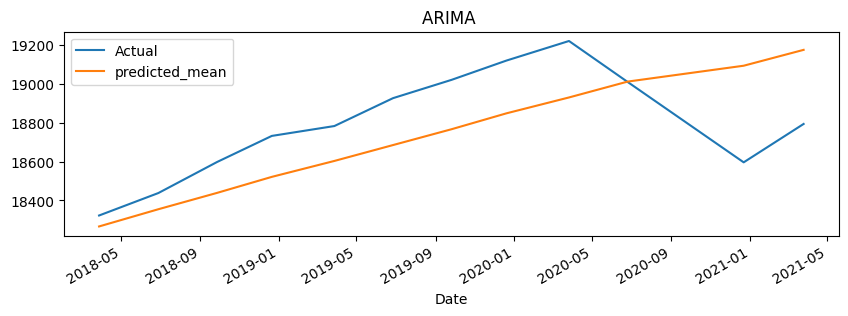

In [83]:
df_pred_arima[['Actual', 'predicted_mean']].plot()
plt.title('ARIMA ')

In [84]:
df_pred_arima

,Actual,first_diff,predicted_mean
Date,,,
2018-03-28,18322.46,158.90,18265.988124
2018-06-28,18438.25,115.79,18354.792206
2018-09-27,18598.13,159.88,18438.965406
2018-12-21,18732.72,134.59,18521.564543
2019-03-28,18783.55,50.83,18603.628648
2019-06-27,18927.28,143.73,18685.510894
2019-09-26,19021.86,94.58,18767.331324
2019-12-20,19121.11,99.25,18849.130742
2020-03-26,19221.97,100.86,18930.923019


### ARIMA metrics using (p,d,q) orders from 'auto_arima'

In [85]:
# p,d,q = (1,2,1) --> using 'auto_arima'

metrics(df_pred_arima['Actual'], df_pred_arima['predicted_mean'])


MSE : 65684.5146549138
RMSE : 256.2899035368225
R-squared : 0.058116499133430644
MAPE : 1.1644699879830087


In [86]:
# pdq = (1,1,3) on original series [through diff / acf / pacf]

# MSE : 233897.62513180645
# RMSE : 483.62963632495314
# R-squared : -3.566331036942567
# MAPE : 1.8893474912944241



# pdq_1970 = (1,1,0) on 1970 data

# MSE : 102202.73475005261
# RMSE : 319.69162446027985
# R-squared : -0.9952811384321794
# MAPE : 1.3185889660193888

# --------------------------------------------------------------------

In [87]:
# zsrhSFh

### Repeating the process with a different p,d,q values of ARIMA (differencing= 1)

In [88]:
model_arima_1_1_3 = statsmodels.tsa.arima.model.ARIMA(train_df_arima['Actual'], order= (1,1,3))
model_arima_1_1_3 = model_arima_1_1_3.fit()
model_arima_1_1_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Actual   No. Observations:                  283
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -1563.008
Date:                Fri, 08 Sep 2023   AIC                           3136.016
Time:                        17:16:14   BIC                           3154.225
Sample:                             0   HQIC                          3143.318
                                - 283                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9988      0.003    308.161      0.000       0.992       1.005
ma.L1         -0.7018      0.046    -15.195      0.000      -0.792      -0.611
ma.L2         -0.0626      0.057     -1.093      0.275      -0.175       0.050
ma.L3         -0.1877      0.051     -3.694      0.000      -0.287      -0.088
sigma2      3788.1844    186.179     20.347      0.000    3423.281    4153.088
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               499.18
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               6.13   Skew:                            -0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [89]:
pred_1_1_3 = model_arima_1_1_3.predict(start= len(train_df_arima['Actual']), end= (len(df_real['Actual'])-1))
len(pred_1_1_3)

12

Text(0.5, 1.0, 'manual pdq order')

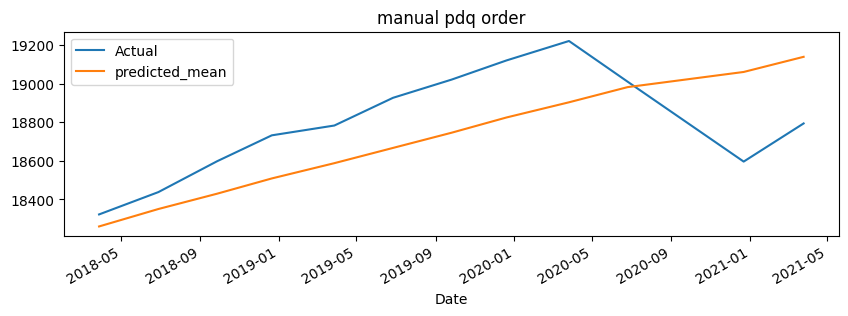

In [90]:
test_df_arima.index
pred_1_1_3 = pred_1_1_3.reset_index()
pred_1_1_3.index = test_df_arima.index
pred_1_1_3

df_pred_1_1_3 = pd.concat([test_df_arima, pred_1_1_3], axis=1)
df_pred_1_1_3.drop(columns= ['index'], inplace= True, axis=1)
df_pred_1_1_3

df_pred_1_1_3[['Actual', 'predicted_mean']].plot()
plt.title('manual pdq order')

In [91]:
df_pred_1_1_3

,Actual,first_diff,predicted_mean
Date,,,
2018-03-28,18322.46,158.90,18260.085574
2018-06-28,18438.25,115.79,18350.529313
2018-09-27,18598.13,159.88,18429.881765
2018-12-21,18732.72,134.59,18509.141113
2019-03-28,18783.55,50.83,18588.307467
2019-06-27,18927.28,143.73,18667.380937
2019-09-26,19021.86,94.58,18746.361630
2019-12-20,19121.11,99.25,18825.249656
2020-03-26,19221.97,100.86,18904.045124


In [92]:
metrics(df_pred_1_1_3['Actual'], df_pred_1_1_3['predicted_mean'])

MSE : 66357.64458633783
RMSE : 257.5997759827012
R-squared : 0.048464148352144854
MAPE : 1.2051650351474785


In [93]:
# pdq = (1,1,3) on original series

# MSE : 97138.5993532473
# RMSE : 311.6706584734073
# R-squared : 0.35377384061912787
# MAPE : 1.4570431885230746

In [94]:
# pdq_1970 = (1,1,0) on 1970 data

# MSE : 102202.73475005261
# RMSE : 319.69162446027985
# R-squared : -0.9952811384321794
# MAPE : 1.3185889660193888

### 1st vs 2nd order differencing

In [95]:
df_real['second_diff'] = df_real['Actual'] - df_real['Actual'].shift(2)
df_real.head()

,Actual,first_diff,second_diff
Date,,,
1947-03-31,2033.06,NaN,NaN
1947-06-30,2027.64,-5.42,NaN
1947-09-30,2023.45,-4.19,-9.61
1947-12-31,2055.10,31.65,27.46
1948-03-31,2086.02,30.92,62.57


<Axes: xlabel='Date'>

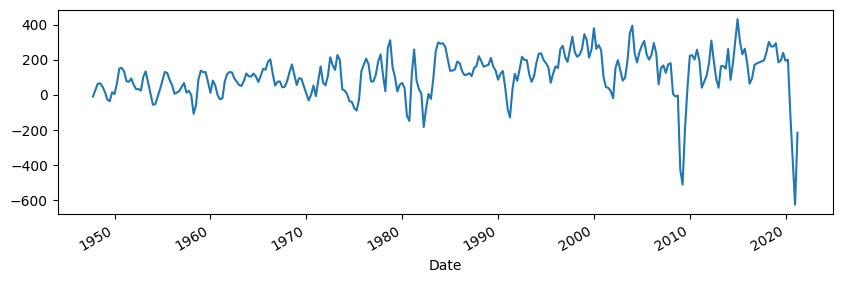

In [96]:
df_real['second_diff'].dropna().plot()

In [97]:
adf_test(df_real['first_diff'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -8.357035e+00
p-value                        2.890487e-13
#Lags Used                     1.000000e+00
Number of Observations Used    2.920000e+02
Critical Value (1%)           -3.452945e+00
Critical Value (5%)           -2.871490e+00
Critical Value (10%)          -2.572071e+00
dtype: float64


In [98]:
adf_test(df_real['second_diff'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -2.905209
p-value                          0.044746
#Lags Used                      16.000000
Number of Observations Used    276.000000
Critical Value (1%)             -3.454267
Critical Value (5%)             -2.872070
Critical Value (10%)            -2.572381
dtype: float64


<Axes: xlabel='Date'>

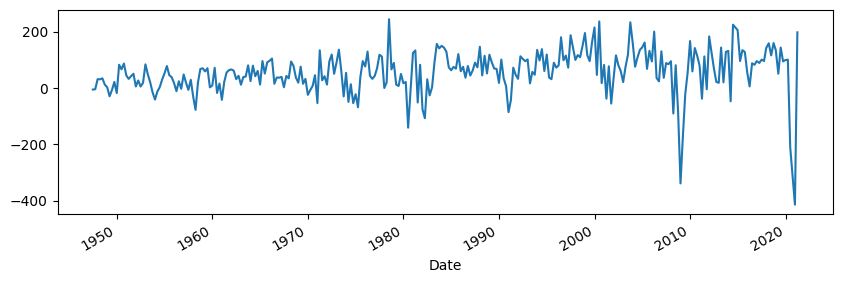

In [99]:
df_real['first_diff'].dropna().plot()

## Starting from a different date (1970)

In [100]:
df_real['date'] = df_real.index
df_real_1970 = df_real[(df_real['date'].dt.year)>= 1970]
df_real_1970.head()

,Actual,first_diff,second_diff,date
Date,,,,
1970-03-31,4936.59,-7.35,-31.57,1970-03-31
1970-06-30,4943.60,7.01,-0.34,1970-06-30
1970-09-30,4989.16,45.56,52.57,1970-09-30
1970-12-31,4935.69,-53.47,-7.91,1970-12-31
1971-03-31,5069.75,134.06,80.59,1971-03-31


In [101]:
adf_test(df_real_1970['Actual'])

Results of Dickey-Fuller Test:
Test Statistic                   0.856672
p-value                          0.992498
#Lags Used                       1.000000
Number of Observations Used    201.000000
Critical Value (1%)             -3.463309
Critical Value (5%)             -2.876029
Critical Value (10%)            -2.574493
dtype: float64


In [102]:
pmd_model_1970 = auto_arima(df_real_1970['Actual'], trace= True, suppress_warnings= True)
pmd_model_1970.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2356.774, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2373.294, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2352.477, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2356.356, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2472.145, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2353.134, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2352.800, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2354.798, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2387.368, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.593 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  203
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1173.239
Date:                Fri, 08 Sep 2023   AIC                           2352.477
Time:                        17:16:16   BIC                           2362.402
Sample:                             0   HQIC                          2356.493
                                - 203                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     46.4447      6.165      7.534      0.000      34.362      58.527
ar.L1          0.3263      0.037      8.865      0.000       0.254       0.398
sigma2      6496.6267    379.953     17.098      0.000    5751.932    7241.321
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               234.87
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               2.51   Skew:                            -1.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [103]:
# Train and Test split

train_df = df_real_1970.iloc[:-12]
test_df = df_real_1970.iloc[-12:]

print(train_df.shape, test_df.shape)

(191, 4) (12, 4)


In [104]:
model_arima_1970 = statsmodels.tsa.arima.model.ARIMA(train_df['Actual'], order= (1,1,0)) # 2,1,3
model_arima_1970 = model_arima_1970.fit()
model_arima_1970.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Actual   No. Observations:                  191
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1099.337
Date:                Fri, 08 Sep 2023   AIC                           2202.674
Time:                        17:16:17   BIC                           2209.168
Sample:                             0   HQIC                          2205.305
                                - 191                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6474      0.063     10.293      0.000       0.524       0.771
sigma2      6188.0629    540.276     11.454      0.000    5129.141    7246.984
===================================================================================
Ljung-Box (L1) (Q):                  21.93   Jarque-Bera (JB):                19.85
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                            -0.35
Prob(H) (two-sided):                  0.09   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [105]:
pred_1970 = model_arima_1970.predict(start= len(train_df['Actual']), end= (len(df_real_1970['Actual'])-1))
len(pred_1970)

12

In [106]:
test_df.index
pred_1970 = pred_1970.reset_index()
pred_1970.index = test_df.index
pred_1970

df_pred_1970 = pd.concat([test_df, pred_1970], axis=1)
df_pred_1970.drop(columns= ['index'], inplace= True, axis=1)
df_pred_1970

,Actual,first_diff,second_diff,date,predicted_mean
Date,,,,,
2018-03-28,18322.46,158.90,301.41,2018-03-28,18255.815701
2018-06-28,18438.25,115.79,274.69,2018-06-28,18315.538628
2018-09-27,18598.13,159.88,275.67,2018-09-27,18354.201042
2018-12-21,18732.72,134.59,294.47,2018-12-21,18379.229657
2019-03-28,18783.55,50.83,185.42,2019-03-28,18395.432257
2019-06-27,18927.28,143.73,194.56,2019-06-27,18405.921221
2019-09-26,19021.86,94.58,238.31,2019-09-26,18412.711388
2019-12-20,19121.11,99.25,193.83,2019-12-20,18417.107090
2020-03-26,19221.97,100.86,200.11,2020-03-26,18419.952706


Text(0.5, 1.0, 'From 1970')

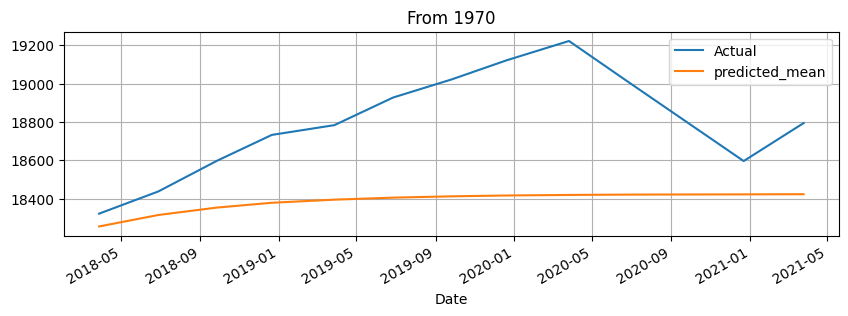

In [107]:
df_pred_1970[['Actual', 'predicted_mean']].plot(legend= True, label= 'From 1970')
plt.grid()
plt.title('From 1970')

In [108]:
metrics(df_pred_1970['Actual'], df_pred_1970['predicted_mean'])

MSE : 220894.0566529214
RMSE : 469.99367724781297
R-squared : -2.1675116805526615
MAPE : 2.1757175114967167


## Starting from Year 2000

In [109]:
df_real_2000 = df_real[(df_real['date'].dt.year)>= 2000]
df_real_2000.head()

,Actual,first_diff,second_diff,date
Date,,,,
2000-03-31,12924.18,46.59,261.79,2000-03-31
2000-06-30,13160.84,236.66,283.25,2000-06-30
2000-09-30,13178.42,17.58,254.24,2000-09-30
2000-12-31,13260.51,82.09,99.67,2000-12-31
2001-03-31,13222.69,-37.82,44.27,2001-03-31


In [110]:
df_real_2000.drop(columns= ['first_diff', 'second_diff'], inplace= True)

In [111]:
adf_test(df_real_2000['Actual'])

Results of Dickey-Fuller Test:
Test Statistic                 -0.232896
p-value                         0.934485
#Lags Used                      1.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


In [112]:
df_real_2000['first_diff'] = df_real_2000['Actual'] - df_real_2000['Actual'].shift(1)
df_real_2000['second_diff'] = df_real_2000['Actual'] - df_real_2000['Actual'].shift(2)
df_real_2000

,Actual,date,first_diff,second_diff
Date,,,,
2000-03-31,12924.18,2000-03-31,NaN,NaN
2000-06-30,13160.84,2000-06-30,236.66,NaN
2000-09-30,13178.42,2000-09-30,17.58,254.24
2000-12-31,13260.51,2000-12-31,82.09,99.67
2001-03-31,13222.69,2001-03-31,-37.82,44.27
...,...,...,...,...
2019-12-20,19121.11,2019-12-20,99.25,193.83
2020-03-26,19221.97,2020-03-26,100.86,200.11
2020-06-25,19010.80,2020-06-25,-211.17,-110.31


In [113]:
adf_test(df_real_2000['first_diff'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -6.527357e+00
p-value                        1.006835e-08
#Lags Used                     0.000000e+00
Number of Observations Used    8.100000e+01
Critical Value (1%)           -3.513790e+00
Critical Value (5%)           -2.897943e+00
Critical Value (10%)          -2.586191e+00
dtype: float64


In [114]:
adf_test(df_real_2000['second_diff'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                 -3.090501
p-value                         0.027264
#Lags Used                      5.000000
Number of Observations Used    75.000000
Critical Value (1%)            -3.520713
Critical Value (5%)            -2.900925
Critical Value (10%)           -2.587781
dtype: float64


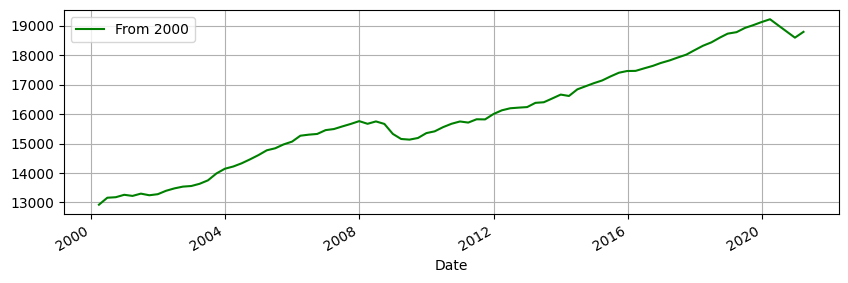

In [115]:
df_real_2000['Actual'].plot(label= 'From 2000', legend= True, color= 'green')
plt.grid()

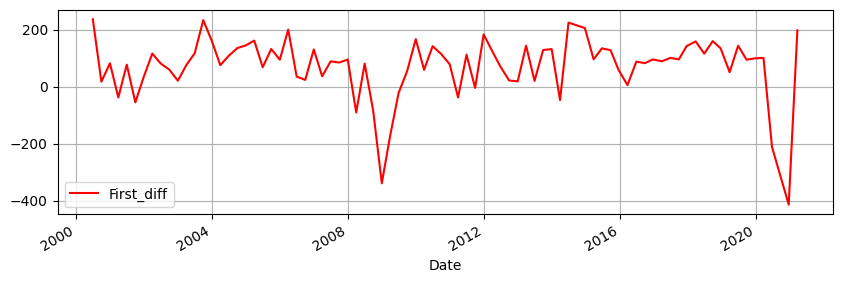

In [116]:
df_real_2000['first_diff'].dropna().plot(label= 'First_diff', legend= True, color= 'red')
plt.grid()

<Axes: xlabel='Date'>

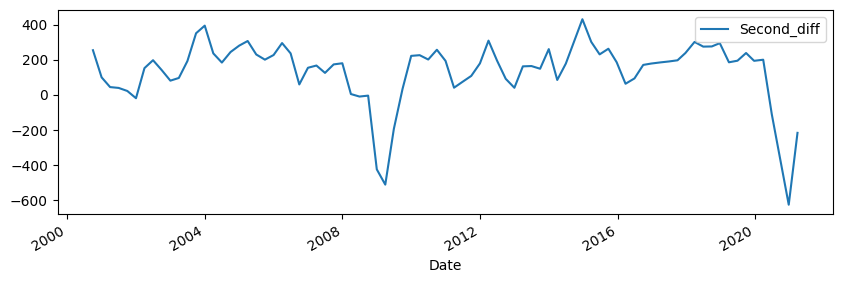

In [117]:
df_real_2000['second_diff'].dropna().plot(label= 'Second_diff', legend= True)

In [118]:
pmd_model_2000 = auto_arima(df_real_2000['Actual'], trace= True, suppress_warnings= True)
pmd_model_2000.summary()



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1001.658, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1003.622, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=996.423, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=996.065, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1031.779, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=998.063, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=998.064, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1000.025, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1012.223, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.355 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   83
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -495.032
Date:                Fri, 08 Sep 2023   AIC                            996.065
Time:                        17:16:19   BIC                           1003.285
Sample:                             0   HQIC                           998.964
                                 - 83                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     72.8032     19.906      3.657      0.000      33.788     111.819
ma.L1          0.3648      0.078      4.675      0.000       0.212       0.518
sigma2      1.041e+04   1227.077      8.482      0.000    8003.277    1.28e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                56.90
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               2.91   Skew:                            -1.20
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

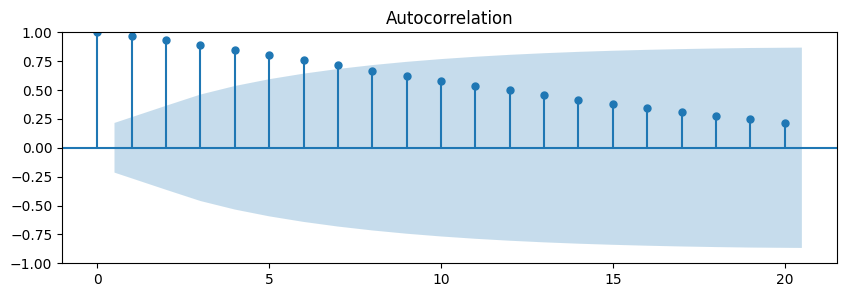

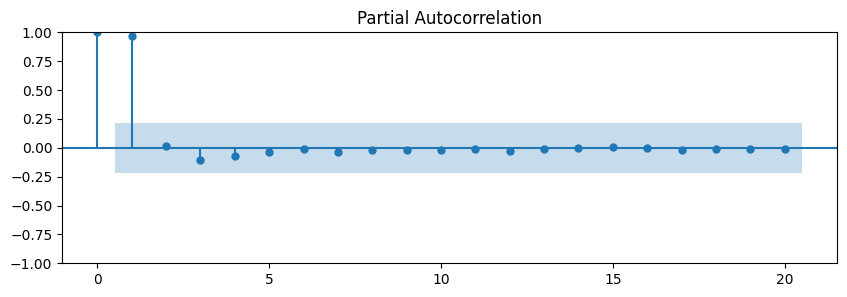

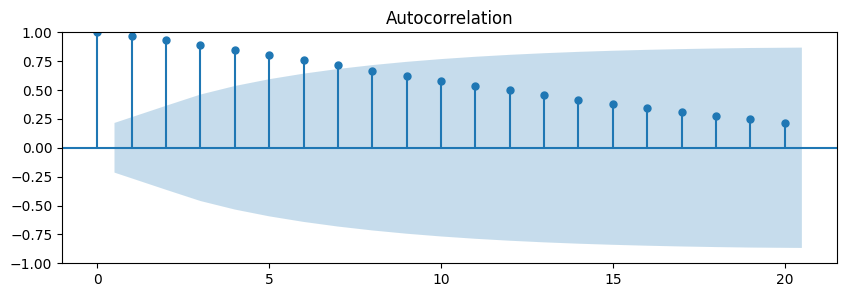

In [119]:
plot_pacf(df_real_2000['Actual'])
plot_acf(df_real_2000['Actual'])

In [120]:
# Train and Test split

train_df_2000 = df_real_2000['Actual'].iloc[:-12]
test_df_2000 = df_real_2000['Actual'].iloc[-12:]

print(train_df_2000.shape, test_df_2000.shape)

(71,) (12,)


In [121]:
train_df_2000

Date
2000-03-31    12924.18
2000-06-30    13160.84
2000-09-30    13178.42
2000-12-31    13260.51
2001-03-31    13222.69
                ...   
2016-12-22    17735.07
2017-03-30    17824.23
2017-06-29    17925.26
2017-09-28    18021.05
2017-12-21    18163.56
Name: Actual, Length: 71, dtype: float64

In [122]:
test_df_2000

Date
2018-03-28    18322.46
2018-06-28    18438.25
2018-09-27    18598.13
2018-12-21    18732.72
2019-03-28    18783.55
2019-06-27    18927.28
2019-09-26    19021.86
2019-12-20    19121.11
2020-03-26    19221.97
2020-06-25    19010.80
2020-12-22    18596.50
2021-03-25    18794.40
Name: Actual, dtype: float64

In [123]:
model_arima_2000 = statsmodels.tsa.arima.model.ARIMA(train_df_2000, order= (0,1,1)) # 2,1,3
model_arima_2000 = model_arima_2000.fit()
model_arima_2000.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Actual   No. Observations:                   71
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -422.853
Date:                Fri, 08 Sep 2023   AIC                            849.707
Time:                        17:16:20   BIC                            854.204
Sample:                             0   HQIC                           851.493
                                 - 71                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4616      0.097      4.761      0.000       0.272       0.652
sigma2      1.064e+04   1916.836      5.549      0.000    6880.124    1.44e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.12   Jarque-Bera (JB):                15.15
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -0.77
Prob(H) (two-sided):                  0.92   Kurtosis:                         4.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [124]:
len(df_real_2000)

83

In [125]:
pred_2000 = model_arima_2000.predict(start= len(train_df_2000), end= (len(df_real_2000)-1))
len(pred_2000)

test_df_2000.index
pred_2000 = pred_2000.reset_index()
pred_2000.index = test_df_2000.index
pred_2000

df_pred_2000 = pd.concat([test_df_2000, pred_2000], axis=1)
df_pred_2000.drop(columns= ['index'], inplace= True, axis=1)
df_pred_2000

,Actual,predicted_mean
Date,,
2018-03-28,18322.46,18216.425593
2018-06-28,18438.25,18216.425593
2018-09-27,18598.13,18216.425593
2018-12-21,18732.72,18216.425593
2019-03-28,18783.55,18216.425593
2019-06-27,18927.28,18216.425593
2019-09-26,19021.86,18216.425593
2019-12-20,19121.11,18216.425593
2020-03-26,19221.97,18216.425593


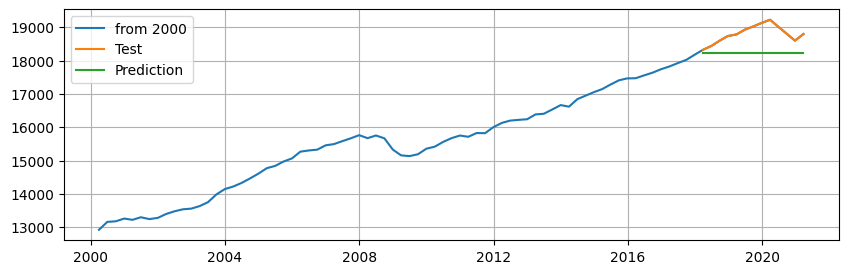

In [126]:
plt.plot(df_real_2000['Actual'], label= 'from 2000')
plt.plot(df_pred_2000['Actual'], label= 'Test')
plt.plot(df_pred_2000['predicted_mean'], label= 'Prediction')
# df_pred_2000[['Actual', 'predicted_mean']].plot(legend= True, label= 'From 2000')
plt.grid()
plt.legend()

Text(0.5, 1.0, 'From 2000')

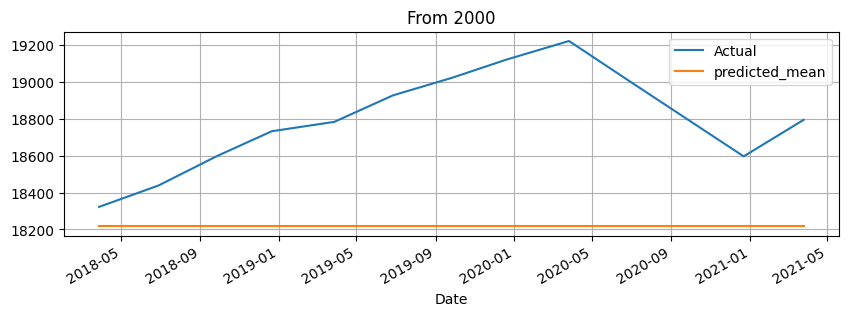

In [127]:
df_pred_2000[['Actual', 'predicted_mean']].plot(legend= True)
plt.grid()
plt.title('From 2000')

In [128]:
metrics(df_pred_2000['Actual'], df_pred_2000['predicted_mean'])

MSE : 407290.9410979366
RMSE : 638.1934981633208
R-squared : -4.840350948590984
MAPE : 3.0716375246467376


Text(0.5, 1.0, 'From 1970')

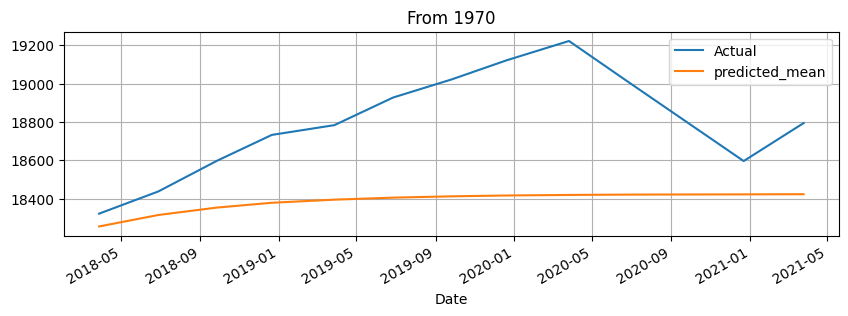

In [129]:
df_pred_1970[['Actual', 'predicted_mean']].plot(legend= True, label= 'From 1970')
plt.grid()
plt.title('From 1970')

In [130]:
metrics(df_pred_1970['Actual'], df_pred_1970['predicted_mean'])

MSE : 220894.0566529214
RMSE : 469.99367724781297
R-squared : -2.1675116805526615
MAPE : 2.1757175114967167


## From Year 1980 ---------------------

In [131]:
# Calling 'Bin' class 

b1_1980 = Bins(df_real, 1980, 12)
og_df_1980 = b1_1980.original_df()
og_df_1980

,Actual,date
Date,,
1980-03-31,6837.64,1980-03-31
1980-06-30,6696.75,1980-06-30
1980-09-30,6688.79,1980-09-30
1980-12-31,6813.53,1980-12-31
1981-03-31,6947.04,1981-03-31
...,...,...
2019-12-20,19121.11,2019-12-20
2020-03-26,19221.97,2020-03-26
2020-06-25,19010.80,2020-06-25


In [132]:
df_train_1980, df_test_1980 = b1_1980.train_test_split()
df_train_1980

Date
1980-03-31     6837.64
1980-06-30     6696.75
1980-09-30     6688.79
1980-12-31     6813.53
1981-03-31     6947.04
                ...   
2016-12-22    17735.07
2017-03-30    17824.23
2017-06-29    17925.26
2017-09-28    18021.05
2017-12-21    18163.56
Name: Actual, Length: 151, dtype: float64

In [133]:
df_test_1980

Date
2018-03-28    18322.46
2018-06-28    18438.25
2018-09-27    18598.13
2018-12-21    18732.72
2019-03-28    18783.55
2019-06-27    18927.28
2019-09-26    19021.86
2019-12-20    19121.11
2020-03-26    19221.97
2020-06-25    19010.80
2020-12-22    18596.50
2021-03-25    18794.40
Name: Actual, dtype: float64

In [134]:
df_1980_diff = b1_1980.diff_df()
df_1980_diff.head()


,Actual,date,first_diff,second_diff
Date,,,,
1980-03-31,6837.64,1980-03-31,NaN,NaN
1980-06-30,6696.75,1980-06-30,-140.89,NaN
1980-09-30,6688.79,1980-09-30,-7.96,-148.85
1980-12-31,6813.53,1980-12-31,124.74,116.78
1981-03-31,6947.04,1981-03-31,133.51,258.25


In [135]:
a = TestArima(df_train_1980, df_test_1980, og_df_1980)
a.orders()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1722.226, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1739.808, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1721.052, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1727.164, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1835.487, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1718.883, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1720.794, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1720.826, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1719.391, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1722.784, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1733.816, Time=0.02 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 0.770 seconds


(2, 1, 0)

In [136]:
a.train_arima()

In [137]:
df_pred_1980= a.predicted_df()
df_pred_1980

,Actual,predicted_mean
Date,,
2018-03-28,18322.46,18259.175533
2018-06-28,18438.25,18348.358986
2018-09-27,18598.13,18419.607314
2018-12-21,18732.72,18480.621291
2019-03-28,18783.55,18531.231548
2019-06-27,18927.28,18573.824551
2019-09-26,19021.86,18609.434093
2019-12-20,19121.11,18639.294971
2020-03-26,19221.97,18664.300863


Text(0.5, 1.0, 'From 1980')

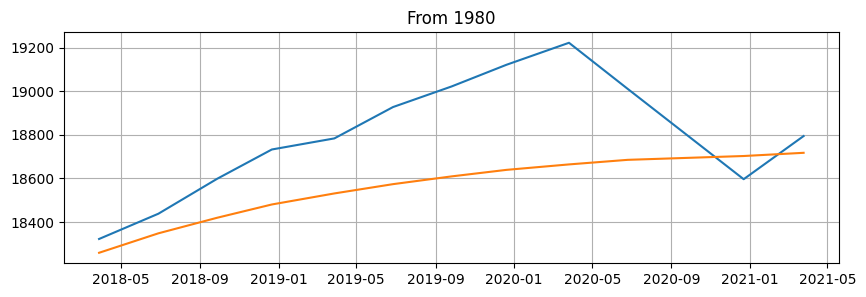

In [138]:
plt.plot(df_pred_1980['Actual'], label= 'test_1980')
plt.plot(df_pred_1980['predicted_mean'], label= 'pred_1980')
plt.grid()
plt.title('From 1980')

In [139]:
metrics(df_pred_1980['Actual'], df_pred_1980['predicted_mean'])

MSE : 94377.78084263996
RMSE : 307.20966918806437
R-squared : -0.3533307673977548
MAPE : 1.3859724031549592


## Holt- Winter's Model (Triple exponential smoothening)

#### ** Captures - level (local mean), trend, seasonality

In [140]:
df_real.head()

,Actual,first_diff,second_diff,date
Date,,,,
1947-03-31,2033.06,NaN,NaN,1947-03-31
1947-06-30,2027.64,-5.42,NaN,1947-06-30
1947-09-30,2023.45,-4.19,-9.61,1947-09-30
1947-12-31,2055.10,31.65,27.46,1947-12-31
1948-03-31,2086.02,30.92,62.57,1948-03-31


In [141]:
train_df_hw = df_real[:-12]
test_df_hw = df_real[-12:]

In [142]:
train_df_hw.tail(), test_df_hw

(              Actual  first_diff  second_diff       date
 Date                                                    
 2016-12-22  17735.07       95.65       178.23 2016-12-22
 2017-03-30  17824.23       89.16       184.81 2017-03-30
 2017-06-29  17925.26      101.03       190.19 2017-06-29
 2017-09-28  18021.05       95.79       196.82 2017-09-28
 2017-12-21  18163.56      142.51       238.30 2017-12-21,
               Actual  first_diff  second_diff       date
 Date                                                    
 2018-03-28  18322.46      158.90       301.41 2018-03-28
 2018-06-28  18438.25      115.79       274.69 2018-06-28
 2018-09-27  18598.13      159.88       275.67 2018-09-27
 2018-12-21  18732.72      134.59       294.47 2018-12-21
 2019-03-28  18783.55       50.83       185.42 2019-03-28
 2019-06-27  18927.28      143.73       194.56 2019-06-27
 2019-09-26  19021.86       94.58       238.31 2019-09-26
 2019-12-20  19121.11       99.25       193.83 2019-12-20
 2020-03-26  

In [143]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_hw = ExponentialSmoothing(train_df_hw['Actual'], trend= 'add', seasonal= 'mul', seasonal_periods= 4).fit()

In [144]:
pred_hw= model_hw.forecast(12)
pred_hw

283    18258.957040
284    18344.280080
285    18473.748154
286    18583.426110
287    18680.591638
288    18765.453525
289    18895.473468
290    19005.247817
291    19102.226236
292    19186.626969
293    19317.198782
294    19427.069524
dtype: float64

In [145]:
pred_hw.reset_index()
pred_hw.index = test_df_hw.index

df_pred_hw = pd.concat([test_df_hw, pred_hw], axis=1)
df_pred_hw

,Actual,first_diff,second_diff,date,0
Date,,,,,
2018-03-28,18322.46,158.90,301.41,2018-03-28,18258.957040
2018-06-28,18438.25,115.79,274.69,2018-06-28,18344.280080
2018-09-27,18598.13,159.88,275.67,2018-09-27,18473.748154
2018-12-21,18732.72,134.59,294.47,2018-12-21,18583.426110
2019-03-28,18783.55,50.83,185.42,2019-03-28,18680.591638
2019-06-27,18927.28,143.73,194.56,2019-06-27,18765.453525
2019-09-26,19021.86,94.58,238.31,2019-09-26,18895.473468
2019-12-20,19121.11,99.25,193.83,2019-12-20,19005.247817
2020-03-26,19221.97,100.86,200.11,2020-03-26,19102.226236


In [146]:
df_pred_hw.columns

Index(['Actual', 'first_diff', 'second_diff', 'date', 0], dtype='object')

Text(0.5, 1.0, "Holt Winter's")

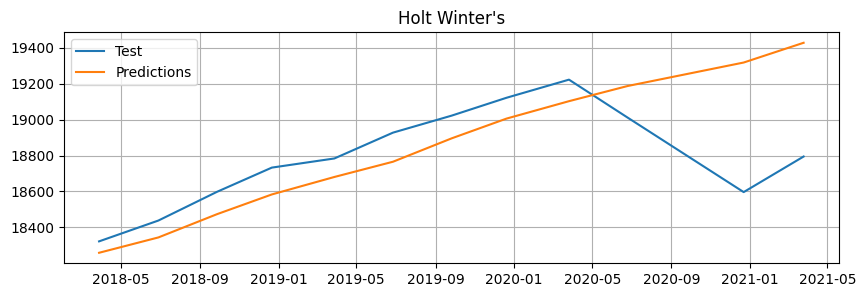

In [147]:
plt.plot(df_pred_hw['Actual'], label= 'Test')
plt.plot(df_pred_hw[0], label= 'Predictions')
plt.legend()
plt.grid()
plt.title('Holt Winter\'s')

In [148]:
metrics(df_pred_hw['Actual'], df_pred_hw[0])

MSE : 90144.95557494984
RMSE : 300.24149542484935
R-squared : -0.2926341435034623
MAPE : 1.1487522445691012


### Metrics for last 4 timestamps [Holt Winter's]

In [149]:
# 1. Trend = 'add', seasonal= 'add'

# MSE : 342871.3255346077
# RMSE : 585.5521544103545
# R-squared : -5.260635681736418
# MAPE : 2.5435078035853773


# 2. Trend = 'mul', seasonal= 'add'

# MSE : 351840.7268940893
# RMSE : 593.1616363977776
# R-squared : -5.424411856683185
# MAPE : 2.5796383414112882 


# 3. Trend = 'add', seasonal= 'mul'

# MSE : 328498.0005034867
# RMSE : 573.1474509264494
# R-squared : -4.998186929526755
# MAPE : 2.483748440969029

# 4. Trend = 'mul', seasonal= 'mul'

# MSE : 336388.33609342104
# RMSE : 579.9899448209607
# R-squared : -5.142259976341606
# MAPE : 2.511842717118593


### Metrics for last 12 timestamps

In [150]:
# 1. Trend = 'add', seasonal= 'add'

# MSE : 92348.63047504109
# RMSE : 303.88917465918576
# R-squared : -0.32423375325279724
# MAPE : 1.126329790794668



# 2. Trend = 'mul', seasonal= 'add'

# MSE : 108288.7140034554
# RMSE : 329.0725056935863
# R-squared : -0.5528066788004056
# MAPE : 1.1266652053982207


# 3. Trend = 'add', seasonal= 'mul'

# MSE : 90144.95557494984
# RMSE : 300.24149542484935
# R-squared : -0.2926341435034623
# MAPE : 1.1487522445691012

# 4. Trend = 'mul', seasonal= 'mul'

# MSE : 103259.64402645444
# RMSE : 321.3403865474342
# R-squared : -0.48069229901201416
# MAPE : 1.152446421267372

## SARIMAX

In [151]:
# Train and Test split

train_df_sarima = df_real.iloc[:-12]
test_df_sarima = df_real.iloc[-12:]

print(train_df_sarima.shape, test_df_sarima.shape)

(283, 4) (12, 4)


In [152]:
train_df_sarima.tail()

,Actual,first_diff,second_diff,date
Date,,,,
2016-12-22,17735.07,95.65,178.23,2016-12-22
2017-03-30,17824.23,89.16,184.81,2017-03-30
2017-06-29,17925.26,101.03,190.19,2017-06-29
2017-09-28,18021.05,95.79,196.82,2017-09-28
2017-12-21,18163.56,142.51,238.30,2017-12-21


In [153]:
test_df_sarima

,Actual,first_diff,second_diff,date
Date,,,,
2018-03-28,18322.46,158.90,301.41,2018-03-28
2018-06-28,18438.25,115.79,274.69,2018-06-28
2018-09-27,18598.13,159.88,275.67,2018-09-27
2018-12-21,18732.72,134.59,294.47,2018-12-21
2019-03-28,18783.55,50.83,185.42,2019-03-28
2019-06-27,18927.28,143.73,194.56,2019-06-27
2019-09-26,19021.86,94.58,238.31,2019-09-26
2019-12-20,19121.11,99.25,193.83,2019-12-20
2020-03-26,19221.97,100.86,200.11,2020-03-26


In [154]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels

model_sarima = statsmodels.tsa.statespace.sarimax.SARIMAX(train_df_sarima['Actual'], order= (1,2,1), seasonal_order= (1,2,1,4)) # 2,1,3
model_sarima = model_sarima.fit()
model_sarima.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.99695D+00    |proj g|=  6.26102D-02

At iterate    5    f=  5.97940D+00    |proj g|=  1.79246D-02

At iterate   10    f=  5.78298D+00    |proj g|=  6.14634D-02

At iterate   15    f=  5.63141D+00    |proj g|=  2.09891D-02

At iterate   20    f=  5.62984D+00    |proj g|=  5.81437D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     28      1     0     0   5.814D-06   5.630D+00
  F =   5.6298360067811846     

CONVERG

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                            Actual   No. Observations:                  283
Model:             SARIMAX(1, 2, 1)x(1, 2, 1, 4)   Log Likelihood               -1593.244
Date:                           Fri, 08 Sep 2023   AIC                           3196.487
Time:                                   17:16:26   BIC                           3214.535
Sample:                                        0   HQIC                          3203.732
                                           - 283                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3074      0.054      5.735      0.000       0.202       0.412
ma.L1         -0.9998      2.579     -0.388      0.698      -6.055       4.055
ar.S.L4       -0.4021      0.049     -8.262      0.000      -0.497      -0.307
ma.S.L4       -0.9990      3.125     -0.320      0.749      -7.123       5.125
sigma2      6120.2110   1.69e+04      0.361      0.718   -2.71e+04    3.93e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):               113.02
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               5.86   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [155]:
pred_sarima = model_sarima.predict(start= len(train_df_sarima['Actual']), end= (len(df_real['Actual'])-1))
len(pred_sarima)

12

In [156]:
test_df_sarima.index
pred_sarima = pred_sarima.reset_index()
pred_sarima.index = test_df_sarima.index
pred_sarima

,index,predicted_mean
Date,,
2018-03-28,283,18238.516627
2018-06-28,284,18341.545739
2018-09-27,285,18435.425236
2018-12-21,286,18562.133218
2019-03-28,287,18643.980884
2019-06-27,288,18747.878720
2019-09-26,289,18844.207149
2019-12-20,290,18979.776134
2020-03-26,291,19059.868988


In [157]:
df_pred_sarima = pd.concat([test_df_sarima, pred_sarima], axis=1)
df_pred_sarima.drop(columns= ['index'], inplace= True, axis=1)
df_pred_sarima

,Actual,first_diff,second_diff,date,predicted_mean
Date,,,,,
2018-03-28,18322.46,158.90,301.41,2018-03-28,18238.516627
2018-06-28,18438.25,115.79,274.69,2018-06-28,18341.545739
2018-09-27,18598.13,159.88,275.67,2018-09-27,18435.425236
2018-12-21,18732.72,134.59,294.47,2018-12-21,18562.133218
2019-03-28,18783.55,50.83,185.42,2019-03-28,18643.980884
2019-06-27,18927.28,143.73,194.56,2019-06-27,18747.878720
2019-09-26,19021.86,94.58,238.31,2019-09-26,18844.207149
2019-12-20,19121.11,99.25,193.83,2019-12-20,18979.776134
2020-03-26,19221.97,100.86,200.11,2020-03-26,19059.868988


,Actual,first_diff,second_diff,date,predicted_mean
Date,,,,,
2018-03-28,18322.46,158.90,301.41,2018-03-28,18238.516627
2018-06-28,18438.25,115.79,274.69,2018-06-28,18341.545739
2018-09-27,18598.13,159.88,275.67,2018-09-27,18435.425236
2018-12-21,18732.72,134.59,294.47,2018-12-21,18562.133218
2019-03-28,18783.55,50.83,185.42,2019-03-28,18643.980884
2019-06-27,18927.28,143.73,194.56,2019-06-27,18747.878720
2019-09-26,19021.86,94.58,238.31,2019-09-26,18844.207149
2019-12-20,19121.11,99.25,193.83,2019-12-20,18979.776134
2020-03-26,19221.97,100.86,200.11,2020-03-26,19059.868988


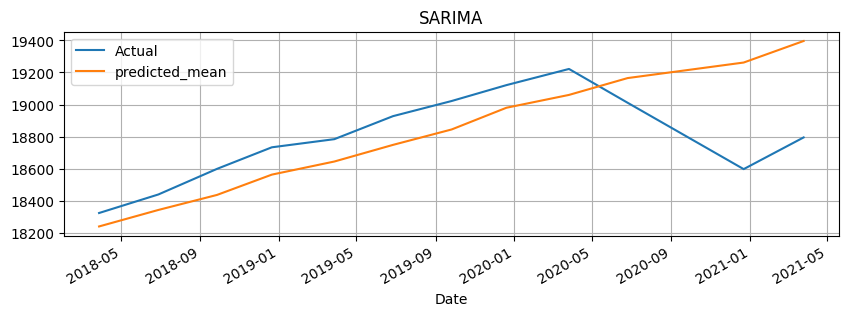

In [158]:
df_pred_sarima[['Actual', 'predicted_mean']].plot()
plt.title('SARIMA')
plt.grid()

df_pred_sarima


In [159]:
## SARIMA metrics

metrics(df_pred_sarima['Actual'], df_pred_sarima['predicted_mean'])

MSE : 85897.70102636029
RMSE : 293.083095770398
R-squared : -0.2317306108471895
MAPE : 1.214121565467984


In [160]:
## ARIMA metrics

metrics(df_pred_arima['Actual'], df_pred_arima['predicted_mean'])

MSE : 65684.5146549138
RMSE : 256.2899035368225
R-squared : 0.058116499133430644
MAPE : 1.1644699879830087


In [161]:
metrics(df_pred_1970['Actual'], df_pred_1970['predicted_mean'])

MSE : 220894.0566529214
RMSE : 469.99367724781297
R-squared : -2.1675116805526615
MAPE : 2.1757175114967167


In [162]:
metrics(df_pred_1980['Actual'], df_pred_1980['predicted_mean'])

MSE : 94377.78084263996
RMSE : 307.20966918806437
R-squared : -0.3533307673977548
MAPE : 1.3859724031549592


In [163]:
metrics(df_pred_2000['Actual'], df_pred_2000['predicted_mean'])

MSE : 407290.9410979366
RMSE : 638.1934981633208
R-squared : -4.840350948590984
MAPE : 3.0716375246467376


In [164]:
## Holt-Winter's metrics

metrics(df_pred_hw['Actual'], df_pred_hw[0])

MSE : 90144.95557494984
RMSE : 300.24149542484935
R-squared : -0.2926341435034623
MAPE : 1.1487522445691012


## LSTM

In [165]:
df_real_lstm = df_real['Actual']
df_real_lstm.head()

Date
1947-03-31    2033.06
1947-06-30    2027.64
1947-09-30    2023.45
1947-12-31    2055.10
1948-03-31    2086.02
Name: Actual, dtype: float64

In [166]:
# original train and test series 

train_df_lstm_org = df_real_lstm.iloc[:-12]
test_df_lstm_org = df_real_lstm.iloc[-12:]

train_df_lstm = train_df_lstm_org.copy()
test_df_lstm = test_df_lstm_org.copy()

train_df_lstm.tail(), test_df_lstm

(Date
 2016-12-22    17735.07
 2017-03-30    17824.23
 2017-06-29    17925.26
 2017-09-28    18021.05
 2017-12-21    18163.56
 Name: Actual, dtype: float64,
 Date
 2018-03-28    18322.46
 2018-06-28    18438.25
 2018-09-27    18598.13
 2018-12-21    18732.72
 2019-03-28    18783.55
 2019-06-27    18927.28
 2019-09-26    19021.86
 2019-12-20    19121.11
 2020-03-26    19221.97
 2020-06-25    19010.80
 2020-12-22    18596.50
 2021-03-25    18794.40
 Name: Actual, dtype: float64)

In [167]:
train_df_lstm = np.array(train_df_lstm)
train_df_lstm = train_df_lstm.reshape(-1,1)
train_df_lstm[:5]

array([[2033.06],
       [2027.64],
       [2023.45],
       [2055.1 ],
       [2086.02]])

In [168]:
test_df_lstm = np.array(test_df_lstm)
test_df_lstm = test_df_lstm.reshape(-1,1)
test_df_lstm

array([[18322.46],
       [18438.25],
       [18598.13],
       [18732.72],
       [18783.55],
       [18927.28],
       [19021.86],
       [19121.11],
       [19221.97],
       [19010.8 ],
       [18596.5 ],
       [18794.4 ]])

In [169]:
from sklearn.preprocessing import MinMaxScaler

mmc = MinMaxScaler()
train_lstm_mmc = mmc.fit_transform(train_df_lstm)
test_lstm_mmc = mmc.transform(test_df_lstm)

test_lstm_mmc

array([[1.00984504],
       [1.01701909],
       [1.02692485],
       [1.0352637 ],
       [1.038413  ],
       [1.04731814],
       [1.05317808],
       [1.05932735],
       [1.06557638],
       [1.05249283],
       [1.02682386],
       [1.03908524]])

In [170]:
from keras.preprocessing.sequence import TimeseriesGenerator

2023-09-08 17:16:33.167177: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 17:16:43.227561: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [171]:
n_input= 4
n_features= 1

generator = TimeseriesGenerator(train_lstm_mmc, train_lstm_mmc, length= n_input, batch_size= 1)

X, y = generator[0] # 0th batch

In [172]:
train_lstm_mmc[:5]

array([[0.00059541],
       [0.0002596 ],
       [0.        ],
       [0.00196095],
       [0.00387668]])

In [173]:
X.flatten(), y

(array([0.00059541, 0.0002596 , 0.        , 0.00196095]),
 array([[0.00387668]]))

In [174]:
X.shape

(1, 4, 1)

In [175]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping


In [176]:
model_lstm = Sequential()
model_lstm.add(LSTM(60, activation= 'relu', input_shape= (n_input, n_features), return_sequences= True))
model_lstm.add(LSTM(60, activation= 'relu'))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer= 'adam', loss= tf.keras.losses.MeanAbsolutePercentageError())

2023-09-08 17:16:51.928177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-08 17:16:52.389577: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [177]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 60)             14880     
                                                                 
 lstm_1 (LSTM)               (None, 60)                29040     
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 43981 (171.80 KB)
Trainable params: 43981 (171.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [178]:
generator[0], generator[1]

((array([[[0.00059541],
          [0.0002596 ],
          [0.        ],
          [0.00196095]]]),
  array([[0.00387668]])),
 (array([[[0.0002596 ],
          [0.        ],
          [0.00196095],
          [0.00387668]]]),
  array([[0.00600987]])))

In [179]:
# Fitting the model 

# early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=True)
# , callbacks= [early_stop]

model_lstm.fit(generator, epochs= 100)

Epoch 1/100
279/279 [==============================] - 2s 2ms/step - loss: 41.6118
Epoch 2/100
279/279 [==============================] - 1s 2ms/step - loss: 14.9644
Epoch 3/100
279/279 [==============================] - 1s 2ms/step - loss: 13.2681
Epoch 4/100
279/279 [==============================] - 1s 2ms/step - loss: 13.6437
Epoch 5/100
279/279 [==============================] - 1s 2ms/step - loss: 9.9408
Epoch 6/100
279/279 [==============================] - 1s 2ms/step - loss: 12.1672
Epoch 7/100
279/279 [==============================] - 1s 2ms/step - loss: 10.5539
Epoch 8/100
279/279 [==============================] - 1s 2ms/step - loss: 9.4921
Epoch 9/100
279/279 [==============================] - 1s 2ms/step - loss: 10.5831
Epoch 10/100
279/279 [==============================] - 1s 2ms/step - loss: 14.7552
Epoch 11/100
279/279 [==============================] - 1s 2ms/step - loss: 8.6577
Epoch 12/100
279/279 [==============================] - 1s 2ms/step - loss: 6.1357
Epoch

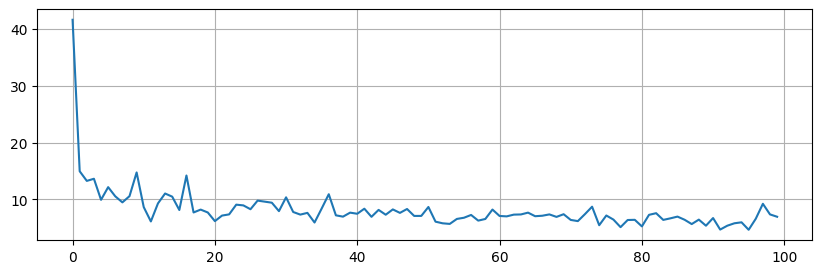

In [180]:
loss_per_epoch = model_lstm.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.grid()

In [181]:
# taking last 4 values from train set to predict the first value of test set
last_train_batch = train_lstm_mmc[-4:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
last_train_batch

array([[[0.97897598],
        [0.98523554],
        [0.99117044],
        [1.        ]]])

In [182]:
model_lstm.predict(last_train_batch)

1/1 [==============================] - 0s 199ms/step


array([[0.9841926]], dtype=float32)

In [183]:
test_lstm_mmc[0]

array([1.00984504])

In [184]:
test_predictions = []

first_eval_batch = train_lstm_mmc[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_df_lstm)):
    
    # get the prediction value for the first batch
    current_pred = model_lstm.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 11ms/step


In [185]:
test_predictions, len(test_predictions)

([array([0.9841926], dtype=float32),
  array([0.9798063], dtype=float32),
  array([0.9799976], dtype=float32),
  array([0.9764302], dtype=float32),
  array([0.97198117], dtype=float32),
  array([0.9693572], dtype=float32),
  array([0.96695906], dtype=float32),
  array([0.964128], dtype=float32),
  array([0.96151245], dtype=float32),
  array([0.959222], dtype=float32),
  array([0.9569959], dtype=float32),
  array([0.95482755], dtype=float32)],
 12)

In [186]:
test_lstm_mmc

array([[1.00984504],
       [1.01701909],
       [1.02692485],
       [1.0352637 ],
       [1.038413  ],
       [1.04731814],
       [1.05317808],
       [1.05932735],
       [1.06557638],
       [1.05249283],
       [1.02682386],
       [1.03908524]])

In [187]:
true_pred_lstm = mmc.inverse_transform(test_predictions)
true_pred_lstm, test_df_lstm

(array([[17908.42698315],
        [17837.6315249 ],
        [17840.7186648 ],
        [17783.14047521],
        [17711.33296611],
        [17668.9817165 ],
        [17630.2755816 ],
        [17584.58225533],
        [17542.36665132],
        [17505.39889654],
        [17469.4691673 ],
        [17434.47164079]]),
 array([[18322.46],
        [18438.25],
        [18598.13],
        [18732.72],
        [18783.55],
        [18927.28],
        [19021.86],
        [19121.11],
        [19221.97],
        [19010.8 ],
        [18596.5 ],
        [18794.4 ]]))

In [188]:
test_df_lstm_org = pd.DataFrame(test_df_lstm_org)
test_df_lstm_org['pred_lstm'] = true_pred_lstm
test_df_lstm_org

,Actual,pred_lstm
Date,,
2018-03-28,18322.46,17908.426983
2018-06-28,18438.25,17837.631525
2018-09-27,18598.13,17840.718665
2018-12-21,18732.72,17783.140475
2019-03-28,18783.55,17711.332966
2019-06-27,18927.28,17668.981717
2019-09-26,19021.86,17630.275582
2019-12-20,19121.11,17584.582255
2020-03-26,19221.97,17542.366651


Text(0.5, 1.0, 'LSTM')

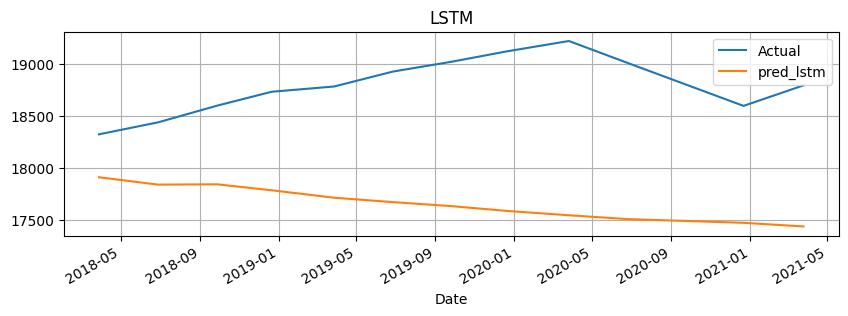

In [189]:
test_df_lstm_org.plot()
plt.grid()
plt.title('LSTM')

In [190]:
# LSTM metrics

metrics(test_df_lstm_org['Actual'], test_df_lstm_org['pred_lstm'])

MSE : 1437069.2724276513
RMSE : 1198.7782415558147
R-squared : -19.606863648351126
MAPE : 6.0266211246937615


Text(0.5, 1.0, 'ARIMA')

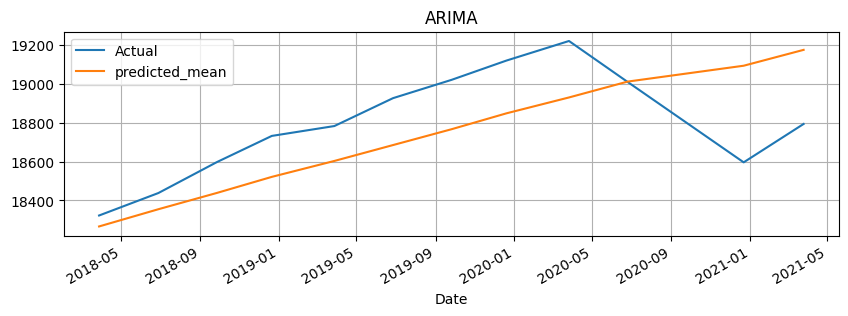

In [191]:
df_pred_arima[['Actual', 'predicted_mean']].plot(legend= True, label= 'ARIMA')
plt.grid()
plt.title('ARIMA')

In [192]:
metrics(df_pred_arima['Actual'], df_pred_arima['predicted_mean'])

MSE : 65684.5146549138
RMSE : 256.2899035368225
R-squared : 0.058116499133430644
MAPE : 1.1644699879830087


Text(0.5, 1.0, 'From 1970 arima')

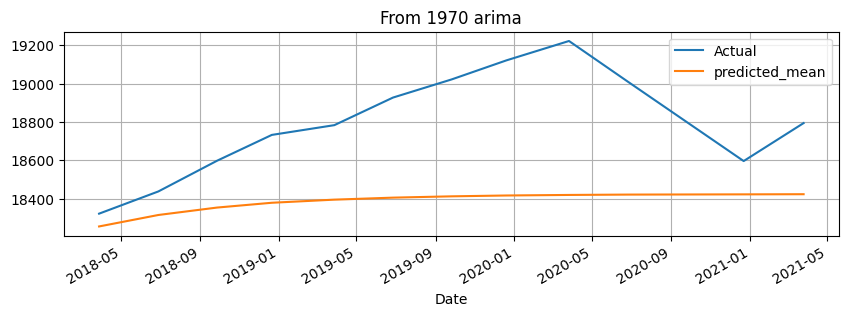

In [193]:
df_pred_1970[['Actual', 'predicted_mean']].plot(legend= True, label= 'From 1970')
plt.grid()
plt.title('From 1970 arima')

In [194]:
metrics(df_pred_1970['Actual'], df_pred_1970['predicted_mean'])

MSE : 220894.0566529214
RMSE : 469.99367724781297
R-squared : -2.1675116805526615
MAPE : 2.1757175114967167


Text(0.5, 1.0, 'From 1980 arima')

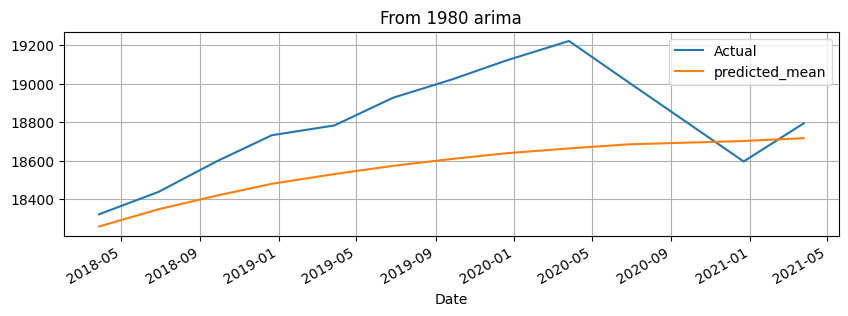

In [195]:
df_pred_1980[['Actual', 'predicted_mean']].plot(legend= True, label= 'From 1980')
plt.grid()
plt.title('From 1980 arima')

In [196]:
metrics(df_pred_1980['Actual'], df_pred_1980['predicted_mean'])

MSE : 94377.78084263996
RMSE : 307.20966918806437
R-squared : -0.3533307673977548
MAPE : 1.3859724031549592


Text(0.5, 1.0, 'From 2000 arima')

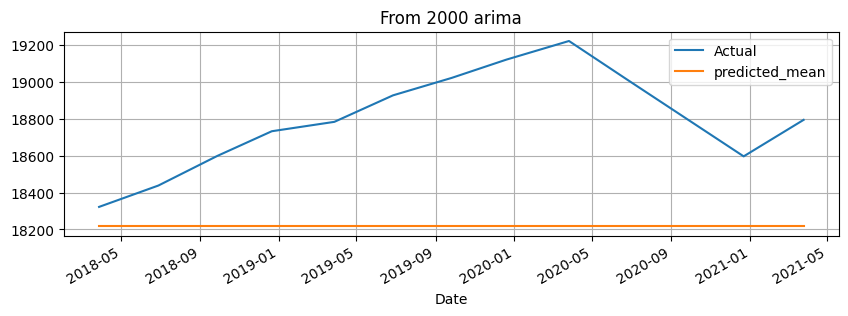

In [197]:
df_pred_2000[['Actual', 'predicted_mean']].plot(legend= True, label= 'From 2000')
plt.grid()
plt.title('From 2000 arima')

In [198]:
metrics(df_pred_2000['Actual'], df_pred_2000['predicted_mean'])

MSE : 407290.9410979366
RMSE : 638.1934981633208
R-squared : -4.840350948590984
MAPE : 3.0716375246467376


Text(0.5, 1.0, 'Holt Winters')

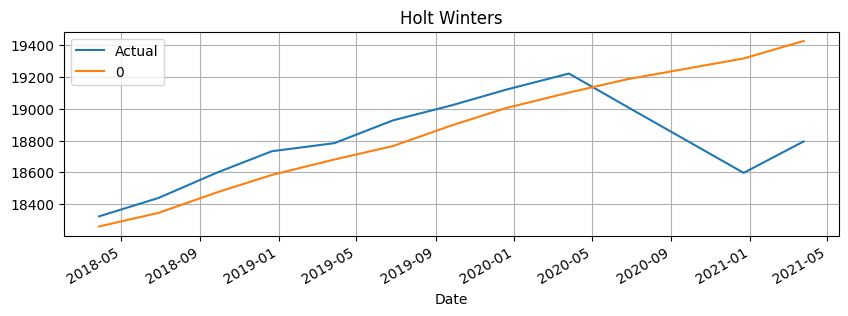

In [199]:
df_pred_hw[['Actual', 0]].plot(legend= True, label= 'Holt Winters')
plt.grid()
plt.title('Holt Winters')

In [200]:
metrics(df_pred_hw['Actual'], df_pred_hw[0])

MSE : 90144.95557494984
RMSE : 300.24149542484935
R-squared : -0.2926341435034623
MAPE : 1.1487522445691012


Text(0.5, 1.0, 'SARIMA')

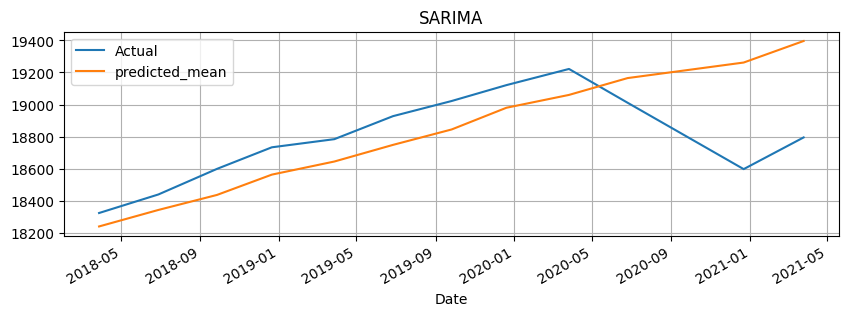

In [201]:
df_pred_sarima[['Actual', 'predicted_mean']].plot(legend= True, label= 'SARIMA')
plt.grid()
plt.title('SARIMA')

In [202]:
metrics(df_pred_sarima['Actual'], df_pred_sarima['predicted_mean'])

MSE : 85897.70102636029
RMSE : 293.083095770398
R-squared : -0.2317306108471895
MAPE : 1.214121565467984


## FB Prophet

In [203]:
df_real_prophet = df_real['Actual']
df_real_prophet.head(), len(df_real_prophet)

(Date
 1947-03-31    2033.06
 1947-06-30    2027.64
 1947-09-30    2023.45
 1947-12-31    2055.10
 1948-03-31    2086.02
 Name: Actual, dtype: float64,
 295)

In [204]:
df_real_prophet = pd.DataFrame(df_real_prophet)
df_real_prophet.reset_index(inplace= True)
df_real_prophet = pd.DataFrame(df_real_prophet)

In [205]:
df_real_prophet.tail()

,Date,Actual
290,2019-12-20,19121.11
291,2020-03-26,19221.97
292,2020-06-25,19010.80
293,2020-12-22,18596.50
294,2021-03-25,18794.40


In [206]:
df_real_prophet.rename(columns= {'Date': 'ds', 'Actual': 'y'}, inplace= True)
df_real_prophet.tail()

,ds,y
290,2019-12-20,19121.11
291,2020-03-26,19221.97
292,2020-06-25,19010.80
293,2020-12-22,18596.50
294,2021-03-25,18794.40


In [207]:
from prophet import Prophet

train_prophet = df_real_prophet.iloc[:-12]
test_prophet = df_real_prophet.iloc[-12:]

In [208]:
train_prophet


,ds,y
0,1947-03-31,2033.06
1,1947-06-30,2027.64
2,1947-09-30,2023.45
3,1947-12-31,2055.10
4,1948-03-31,2086.02
...,...,...
278,2016-12-22,17735.07
279,2017-03-30,17824.23
280,2017-06-29,17925.26
281,2017-09-28,18021.05


In [209]:
model_prophet = Prophet()
model_prophet.fit(train_prophet)

17:17:54 - cmdstanpy - INFO - Chain [1] start processing
17:17:54 - cmdstanpy - INFO - Chain [1] done processing


## ML Approach

In [210]:
df_real_ml = df_real.copy()
df_real_ml.head()


# Differencing the time series

df_real_ml['lag_1_q'] = df_real_ml['Actual'].shift(1)
df_real_ml['lag_2_q'] = df_real_ml['Actual'].shift(2)
df_real_ml['lag_3_q'] = df_real_ml['Actual'].shift(3)

In [211]:
df_real_ml.drop(columns= ['first_diff', 'second_diff'], axis= 1, inplace= True)
df_real_ml.dropna(inplace= True)

In [212]:
df_real_ml.head()

,Actual,date,lag_1_q,lag_2_q,lag_3_q
Date,,,,,
1947-12-31,2055.10,1947-12-31,2023.45,2027.64,2033.06
1948-03-31,2086.02,1948-03-31,2055.10,2023.45,2027.64
1948-06-30,2120.45,1948-06-30,2086.02,2055.10,2023.45
1948-09-30,2132.60,1948-09-30,2120.45,2086.02,2055.10
1948-12-31,2134.98,1948-12-31,2132.60,2120.45,2086.02


In [213]:
# Correlation 

df_real_ml.corr()

,Actual,date,lag_1_q,lag_2_q,lag_3_q
Actual,1.000000,0.983167,0.999900,0.999733,0.999538
date,0.983167,1.000000,0.982871,0.982554,0.982281
lag_1_q,0.999900,0.982871,1.000000,0.999900,0.999741
lag_2_q,0.999733,0.982554,0.999900,1.000000,0.999916
lag_3_q,0.999538,0.982281,0.999741,0.999916,1.000000


In [214]:
X = df_real_ml.drop(columns= ['date', 'Actual'], axis=1)
y = df_real_ml['Actual']

In [215]:
# x1,x2,x3,y=df_real_ml['lag_1_q'], df_real_ml['lag_2_q'], df_real_ml['lag_3_q'], df_real_ml['Actual']
# x1,x2,x3,y=np.array(x1), np.array(x2), np.array(x3), np.array(y)
# x1,x2,x3,y=x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),y.reshape(-1,1)
# X= np.concatenate((x1,x2,x3), axis=1)

In [227]:
X[-12:], y[-12:]

(             lag_1_q   lag_2_q   lag_3_q
 Date                                    
 2018-03-28  18163.56  18021.05  17925.26
 2018-06-28  18322.46  18163.56  18021.05
 2018-09-27  18438.25  18322.46  18163.56
 2018-12-21  18598.13  18438.25  18322.46
 2019-03-28  18732.72  18598.13  18438.25
 2019-06-27  18783.55  18732.72  18598.13
 2019-09-26  18927.28  18783.55  18732.72
 2019-12-20  19021.86  18927.28  18783.55
 2020-03-26  19121.11  19021.86  18927.28
 2020-06-25  19221.97  19121.11  19021.86
 2020-12-22  19010.80  19221.97  19121.11
 2021-03-25  18596.50  19010.80  19221.97,
 Date
 2018-03-28    18322.46
 2018-06-28    18438.25
 2018-09-27    18598.13
 2018-12-21    18732.72
 2019-03-28    18783.55
 2019-06-27    18927.28
 2019-09-26    19021.86
 2019-12-20    19121.11
 2020-03-26    19221.97
 2020-06-25    19010.80
 2020-12-22    18596.50
 2021-03-25    18794.40
 Name: Actual, dtype: float64)

In [228]:
X_train_lin, X_test_lin, y_train_lin, y_test_lin = X[:-12], X[-12:], y[:-12], y[-12:]

In [229]:
from sklearn.linear_model import LinearRegression
model_linear= LinearRegression()

model_linear.fit(X_train_lin, y_train_lin)
pred_lin = model_linear.predict(X_test_lin)


In [230]:
pred_lin, y_test_lin.index

(array([18273.31991077, 18444.98300728, 18551.11235411, 18717.15532763,
        18851.85731076, 18874.20409744, 19031.66644066, 19127.28883007,
        19220.07574678, 19322.3837889 , 19019.92447287, 18494.41003264]),
 DatetimeIndex(['2018-03-28', '2018-06-28', '2018-09-27', '2018-12-21',
                '2019-03-28', '2019-06-27', '2019-09-26', '2019-12-20',
                '2020-03-26', '2020-06-25', '2020-12-22', '2021-03-25'],
               dtype='datetime64[ns]', name='Date', freq=None))

In [231]:
y_test_lin

Date
2018-03-28    18322.46
2018-06-28    18438.25
2018-09-27    18598.13
2018-12-21    18732.72
2019-03-28    18783.55
2019-06-27    18927.28
2019-09-26    19021.86
2019-12-20    19121.11
2020-03-26    19221.97
2020-06-25    19010.80
2020-12-22    18596.50
2021-03-25    18794.40
Name: Actual, dtype: float64

In [232]:
pred_lin = pd.DataFrame(pred_lin, index= y_test_lin.index)
df_linear = pd.concat([y_test_lin, pred_lin], axis=1)
df_linear.head()

,Actual,0
Date,,
2018-03-28,18322.46,18273.319911
2018-06-28,18438.25,18444.983007
2018-09-27,18598.13,18551.112354
2018-12-21,18732.72,18717.155328
2019-03-28,18783.55,18851.857311


Text(0.5, 1.0, 'Linear Regression')

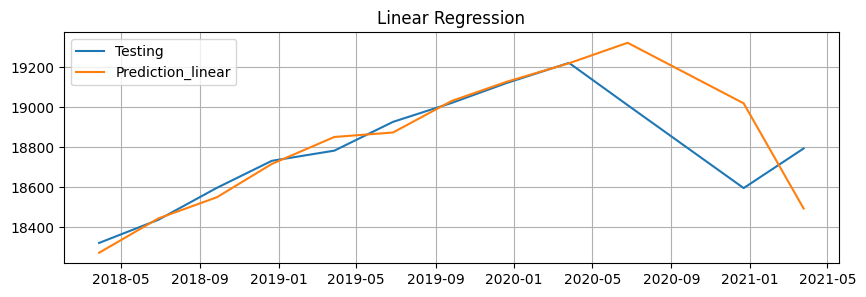

In [233]:
plt.plot(df_linear['Actual'], label = 'Testing')
plt.plot(df_linear[0], label = 'Prediction_linear')
plt.legend()
plt.grid()
plt.title('Linear Regression')

In [234]:
metrics(df_linear['Actual'], df_linear[0])

MSE : 31575.049550668697
RMSE : 177.69369586642262
R-squared : 0.5472293832562496
MAPE : 0.5742050335803631
